# MLOps 워크플로우를 SageMaker로 구현하기



# 0. 질문사항
1. 저는 산출물을 특정 s3 버킷에 넣고 싶은데 계속 sagemaker-[region]-[region NUM]-[ACCOUNT NUMBER] 버킷에 들어가는데 어칼까요?
2. preprocessing을 수행하는 곳에 library를 설치하고 싶은데 어떻게 해야할까요?
3. AWS 서비스에 접근할때, client vs resource 차이점이 무엇인가요?

1. 목차
   0. 데이터 추출(Lambda)
        - From Data lake To palm-oil-price-forecast/staged-data
   1. 데이터 전처리(SageMaker Processing)
        - From staged-data to golden-data
        - S3내 데이터읽기 -> raw.csv 합치기 -> 전처리(preprocessing.py) -> golden-data/[yyyy][mm][dd][ts]_processed.csv로 저장
        - 수행 목록 : 원자재데이터(raw.csv) 합치기, Scaling data, Fill missing data
   2. 모델 훈련(SageMaker Train)
       - From golden-data to trained model
       - S3내 데이터읽기 -> AutoGluon 모델링(train.py) -> modeling/yyyymmddts/Model(.h5), Metric(leaderboard) 저장. 
<!--     - 모델 하이퍼파라미터 튜닝(SageMaker의 Automatic Model Tuning) -->
     
   3. 모델검증(SageMaker Processing)
       - From trained-model
       - S3내 leaderboard 읽기 -> Top1 모델 찾기 -> S3내 TOP1 model(.h5) 읽기 -> Inference(inference.py) -> 결과 저장-> Model Registry 등록
   4. 모델배포(QuickSight)
       - From validated-model to LAS VEGAS!!!!
       - 모델검증시 예측값, 실제값 비교 자료
       - Approve시, AWS SageMaker Batch Transform으로 배포
       
2. 데이터: stage-data 내 데이터
   - Date
   - HIGH
   - CLOSE
   - LOW
   - OPEN
   - VOLUME
   - RIC
   
3. 시간소요: ?

4. 질문사항
    - 학습(train) 스크립트를 SageMaker가 아닌 **컨테이너**에서 실행하도록 하고 싶다.
    - 하드코딩이 아니라 SageMaker, Lambda에서 자유자재로 Access Key, Secret Access Key를 꺼내쓰고 싶은데, 보안이 신경쓰인다.
      => Secret Manager
5. 참고한 자료
    - https://github.com/lunarian60/sagemaker-processing/blob/main/scikit_learn_data_processing.ipynb

# 0. 환경구성
- 필요한 패키지 임포트
- 작업 디렉토리 세팅 : local에서 학습과 테스트를 하기 위해)
- SageMaker Session: 다양한 작업을 위해)
- S3 버킷 정의:입출력 데이터 저장
- 버킷: SageMaker가 자동으로 생성하는 디폴트 버킷을 사용할 것입니다. 디폴트 버킷의 이름은 여러분의 Account ID와 리전을 포함하고 있습니다.

In [7]:
import os
import json
import boto3
import pandas as pd
import numpy as np
import base64
from botocore.exceptions import ClientError
from io import StringIO
import time
from botocore.client import Config
from datetime import datetime as dt
import datetime

from pytz import timezone
from dateutil.relativedelta import *

from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
import sagemaker, boto3, os

from collections import OrderedDict

from matplotlib import pyplot as plt

import copy

In [8]:
def get_list_in_s3(key_id : str,
                secret_key_id : str,
                bucket_name : str,
                s3_path : str) -> list:
    
    s3 = boto3.client('s3',
                      aws_access_key_id = ACCESS_KEY_ID,
                      aws_secret_access_key = ACCESS_SECRET_KEY,
                      region_name = 'ap-northeast-2')
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket = bucket_name,
                               Prefix = s3_path)  # 원하는 bucket 과 하위경로에 있는 object list # dict type
    contents_list = [] # object list의 Contents를 가져옴
    for page in pages:
        for obj in page['Contents']:
            contents_list.append(obj)
    return contents_list

def get_key_in_diclist(diclst : list):
    flist = []
    for dic in diclst:
        key = dic['Key']
        flist.append(key)
    return flist

def download_df_from_S3(key_id : str,
                        secret_key_id : str,
                        bucket_name : str,
                        s3_path : str) -> pd.DataFrame:
    try:
        sesssion = boto3.Session(key_id, secret_key_id)
        s3_resource = sesssion.resource('s3')
        bucket = s3_resource.Bucket(bucket_name)
        findData = bucket.objects.filter(Prefix=s3_path)
        # assert len(list(filter(bool, [obj.key.split('/')[1].split('.')[0] for obj in findData]))) == 1 , '동일한 이름의 파일이 0개 혹은 2개 이상 존재합니다.'
        for obj in bucket.objects.filter(Prefix=s3_path):
            key = obj.key
            if key.split('/')[1] == '': continue
            body = obj.get()['Body']
            csv_string = body.read().decode('utf-8')
            df = pd.read_csv(StringIO(csv_string))
        return df
    except Exception as e:
        return e
    
def upload_df_to_S3(key_id : str,
                    secret_key_id : str,
                    bucket_name : str,
                    s3_path : str,
                    df : pd.DataFrame) -> None:
    try:
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=False)
        s3_resource = boto3.resource(
            's3',
            aws_access_key_id=key_id,
            aws_secret_access_key=secret_key_id,
            config=Config(signature_version='s3v4')
        )
        code = s3_resource.Object(bucket_name, s3_path).put(Body = csv_buffer.getvalue())
        if code['ResponseMetadata']['HTTPStatusCode'] == 200:
            return f'Complete uploading data to {s3_path} in AWS S3'
        else:
            raise Exception('\nHTTPStautsCode is not 200\nPlease See below error message\n'+code)
    except Exception as e:
        return '\n'+e

def get_secret():
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    secret_name = "prod/sagemaker"
    region_name = "ap-northeast-2"
    
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId='prod/sagemaker',
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException': # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException': # An error occurred on the server side.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException': # You provided an invalid value for a parameter.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException': # You provided a parameter value that is not valid for the current state of the resource.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException': # We can't find the resource that you asked for.
            raise e
    else:
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return secret
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return decoded_binary_secret

In [3]:
%%bash
cat /proc/version
cat /proc/meminfo | grep MemTotal
grep -c processor /proc/cpuinfo
# cat /proc/cpuinfo

Linux version 5.10.102-99.473.amzn2.x86_64 (mockbuild@ip-10-0-35-1) (gcc10-gcc (GCC) 10.3.1 20210422 (Red Hat 10.3.1-1), GNU ld version 2.35-21.amzn2.0.1) #1 SMP Wed Mar 2 19:14:12 UTC 2022
MemTotal:       31824204 kB
16


In [4]:
keychain = json.loads(get_secret())
ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
S3_PATH_STAGE = keychain['S3_PATH_STAGE']
S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
S3_PATH_log = keychain['S3_PATH_LOG']

boto3_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)
sm_session = sagemaker.Session(boto_session = boto3_session)
region = boto3_session.region_name

s3_resource = boto3_session.resource('s3')
bucket = s3_resource.Bucket(BUCKET_NAME_USECASE)
s3_client = boto3_session.client('s3')


# 1. SageMaker Processing을 이용한 데이터 전처리(정제)
**워크플로우 요약**
   1. Stage 데이터셋 가지고 오기
   2. First preprocessing: ric 선정 -> 컬럼삭제 -> 형변환 -> 훈련을 위한 dataset로 만들기
   3. SageMaker Processing을 이용한 데이터 전처리   
   4. trainset, testset 나누기
   5. S3 버킷내 golden-data 폴더에 업로드
   6. 학습과 테스트를 위해 레이블 생성 & 저장.
   
**SageMaker Processing?**
- SageMaker 노트북 서버와 분리된 독립적 환경에서 테라바이트 수준의 데이터를 변환처리 가능.   
- 일반적으로 Prototyping 작업에 사용되는 노트북은 SageMaker 일반 사양에서 실행하며 전처리, 학습, 모델 호스팅과 같은 작업은 강력한 사양의 인스턴스에서 실행.    
- SageMaker Processing은 Scikit-learn이 기본 탑재되어 있으며 **Bring Your Own Container** 옵션으로 다양한 데이터 정제 작업을 별도 독립된 환경에서 실행 가능

## 1) Stage Data 폴더 내 데이터들 리스트로 가져오기
- S3 Stage data 버킷 내 데이터들 읽기

In [5]:
dt.today()

datetime.datetime(2022, 10, 25, 13, 9, 8, 929366)

In [6]:
# 폴더 내 파일 리스트 가지고 옴
path_list = []

list_in_stage_dir = get_list_in_s3(ACCESS_KEY_ID,
                                   ACCESS_SECRET_KEY,
                                   BUCKET_NAME_USECASE,
                                   S3_PATH_STAGE)
for dic in list_in_stage_dir:
    key = dic['Key']
    if key[-1] == '/': continue # 만약 폴더형태이면, path 안가지고온다.
    path_list.append(key)
print('데이터수:',len(path_list))
print('마지막 데이터 날짜:',path_list[-1])

데이터수: 12499
마지막 데이터 날짜: staged-data/2022/10/24/1666592130.0/raw.csv


## 2) 추출한 데이터 전처리를 위해 묶기
- golden-data/[yyyy]/[mm]/[dd]/[ts].csv 형태로 저장
- From staged-data To golden-data

In [45]:
os.listdir(raw_dir)

['1666735766.csv']

In [46]:
%%time
# 파일 리스트로 부터 파일들 가지고 와서 한개의 데이터셋으로 붙이기
start = time.time()

df_raw = pd.DataFrame()
KST = dt.today() + relativedelta(hours=9)
raw_dir = os.path.join(os.getcwd(),'data/raw', KST.strftime('%Y/%m/%d'))

if not os.path.exists(raw_dir): #만약 raw_dir이라는 변수가 선언조차 안되었다 => 오늘날짜의 데이터 추출이 안되었다는 뜻이므로 추출 수행
    for stage_data in path_list: # stage-data 내 데이터들
        df_tmp = download_df_from_S3(ACCESS_KEY_ID,
                                     ACCESS_SECRET_KEY,
                                     BUCKET_NAME_USECASE,
                                     stage_data)
        df_raw = pd.concat([df_raw, df_tmp])
    os.makedirs(raw_dir, exist_ok=True) # 폴더 생성
    df_raw = df_raw.reset_index(drop=True)
    df_raw.to_csv(os.path.join(raw_dir, # 로컬에 하나 저장하자.
                               '{}.csv'.format(int(time.mktime(KST.timetuple())))),
                  index=False)
    
else:
    raw_dir_ts = os.path.join(raw_dir, os.listdir(raw_dir)[0])
    df_raw = pd.read_csv(os.path.join(raw_dir_ts,
                                      '{}.csv'.format(int(time.mktime(KST.timetuple())))))
upload_df_to_S3(ACCESS_KEY_ID,
                ACCESS_SECRET_KEY,
                BUCKET_NAME_USECASE,
                os.path.join(S3_PATH_GOLDEN,
                             KST.strftime('%Y/%m/%d'),
                             '{}.csv'.format('stage'),
                df_raw)
end = time.time()

CPU times: user 19min 26s, sys: 1min 30s, total: 20min 57s
Wall time: 35min 32s


In [47]:
print(f"Staging Data 시간 : {end - start:.1f} sec")
print(f"Staging Data 시간 : {((end - start)/60):.1f} min")

Staging Data 시간 : 2132.1 sec
Staging Data 시간 : 35.5 min


In [78]:
upload_df_to_S3(ACCESS_KEY_ID,
                ACCESS_SECRET_KEY,
                BUCKET_NAME_USECASE,
                os.path.join(S3_PATH_GOLDEN,
                             KST.strftime('%Y/%m/%d'),
                             '{}.csv'.format('stage')),
                df_raw)

'Complete uploading data to golden-data/2022/10/26/stage.csv in AWS S3'

\[2022년 10월 20일 기준\]   
Download and Concat Staging Data 시간 : **2206.9 sec(36.8 min)**

\[2022년 10월 25일 기준\]   
Download and Concat Staging Data 시간 : **2132.1 sec(35.5 min)**

### (별첨)merge를 사용하지 못하는 이유

In [85]:
test_merge_raw = pd.DataFrame(columns=['Date','HIGH','LOW','OPEN','CLOSE','VOLUME','RIC'])
test_merge_tmp1 = df_tmp
test_merge_tmp2 = df_tmp2

In [86]:
test_merge_raw

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC


In [88]:
test_merge_tmp1.head()

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX


In [89]:
test_merge_tmp2.head()

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-03,23.99,23.72,23.85,23.9200,NaN,BOc1
1,1980-01-03,24.35,24.02,24.15,24.3200,NaN,BOc2
2,1980-01-03,24.65,24.40,24.55,24.6200,NaN,BOc3
3,1980-01-03,NaN,NaN,NaN,1.1703,NaN,CAD=
4,1980-01-03,NaN,NaN,NaN,1.5177,NaN,EUR=


In [87]:
pd.merge(test_merge_raw,
         test_merge_tmp1, 
         how = 'outer',
         on = 'RIC')

,Date_x,HIGH_x,LOW_x,OPEN_x,CLOSE_x,VOLUME_x,Date_y,HIGH_y,LOW_y,OPEN_y,CLOSE_y,VOLUME_y,RIC
0,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX


In [90]:
pd.merge(test_merge_raw,
         test_merge_tmp1) 
         # how = 'outer',
         # on = 'RIC')

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC


In [91]:
pd.concat([test_merge_raw,
           test_merge_tmp1])

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX


### ** 3)과 4)는 preprocessing으로 처리할 부분이다. 
- 2)까지는 Lambda로 combine staging data하면 되긴 하는데, Sagemaker로 합칠 수 없을까?
- 3), 4)는 preprocessing으로 충분히 할 수 있다.

- 상단의 데이터는 Merge로 했을때의 소요시간과 비교해서 알맞는것으로 설정하자
    => 못쓴다.
- Lambda로 Golden-data로 옮겨주는 작업을 주기적으로 수행하도록 하자.
    => 되나?

In [48]:
df_raw

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.38,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.94,NaN,SPX
2,1980-01-02,23.98,23.63,23.80,23.83,NaN,BOc1
3,1980-01-02,24.35,24.00,24.20,24.13,NaN,BOc2
4,1980-01-02,24.70,24.38,24.65,24.50,NaN,BOc3
...,...,...,...,...,...,...,...
893395,2022-10-24,1402.75,1377.75,1402.75,1381.50,93674.0,Sc2
893396,2022-10-24,1410.00,1386.00,1410.00,1389.25,22126.0,Sc3
893397,2022-10-24,856.50,833.50,853.75,839.50,36624.0,Wc1
893398,2022-10-24,875.75,853.25,873.00,858.25,13915.0,Wc2


**시각화 테스트**

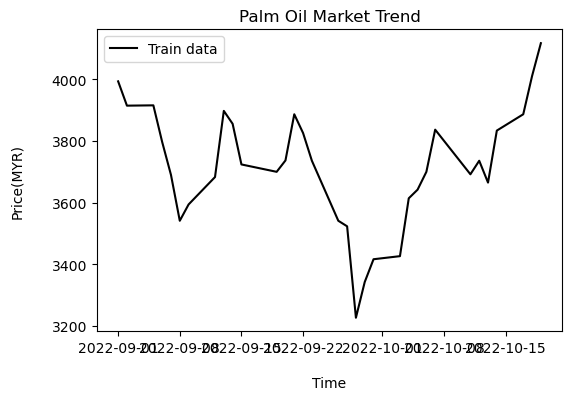

In [49]:
test = df_raw[df_raw['Date'] > '2022-09'].reset_index(drop=True)
test = test[test['RIC'] == 'FCPOc3']
test.loc[:, "Date"] = pd.to_datetime(test.loc[:, "Date"])
plt.figure(dpi=100)
plt.plot(test['Date'].values,
         test['CLOSE'].values,
         'black', label="Train data")
plt.xlabel('Time', labelpad=15)
plt.ylabel('Price(MYR)', labelpad=20)

plt.title(f'Palm Oil Market Trend')
plt.legend()
plt.show()

## 3) Data cleansing
- EDA에서 선정한 RIC 코드 선별
- 컬럼삭제
- 형변환 
- EDA를 통한 Date별 데이터 선별
- 종합하여 1차 dataset로 만들기

In [50]:
ric_list_ex01 = ['BOc1', 'BOc2', 'BOc3','BOPLKL','BRRTSc1', 'BRRTSc2', 'BRRTSc3', 'CAD=', 'EUR=', 'JPY=', 'KRW=', 'MYR=', 'GBP=', 'INR=','Cc1', 'Cc2', 'Cc3','CCMc1', 'CCMc2', 'CCMc3',
                 'CLc1', 'CLc2', 'CLc3','CNY=','COMc1', 'COMc2','COMc3','CTc1', 'CTc2', 'CTc3', 'DJCI', 'DJCIBR', 'DJCICL', 'DJCICN', 'DJCIEN', 'DJCIGR', 'DJCIIA', 'DJCING', 
                 'DJCISO', 'DJCIWH', 'DJT','FCHI','FCPOc1', 'FCPOc2', 'FCPOc3','FGVHKL',
                 'FKLIc1', 'FKLIc2', 'FKLIc3','FTSE','GCc1', 'GCc2', 'GCc3','GDAXI','GENMKL','HSI','IOIBKL','IXIC','JNIc1','JNIc2','JNIc3','KCc1', 'KCc2', 'KCc3','KLKKKL','KLSE','KQ11', 'KS11',
                 'KWc1', 'KWc2', 'KWc3','LCOc1', 'LCOc2', 'LCOc3','LWBc1', 'LWBc2', 'LWBc3','MCCc1', 'MCCc2', 'MCCc3','MXSCKL','Oc1', 'Oc2', 'Oc3','PEPTKL','RRc1', 'RRc2', 'RRc3','RSc1', 'RSc2', 'RSc3',
                 'Sc1', 'Sc2', 'Sc3','SIMEKL','SOPSKL','SSEC', 'THPBKL', 'Wc1', 'Wc2', 'Wc3'
                ] #SPX,VIX 더이상 지원안하므로 제거
print('얼마나 데이터 필터링 되었는가?',len(df_raw) - len(df_raw[df_raw['RIC'].isin(ric_list_ex01)]))

얼마나 데이터 필터링 되었는가? 19060


In [51]:
%%time
start = time.time()

data_dir = "raw-data/"

df_list = OrderedDict()
# (1) EDA에서 선정한 RIC 코드 선별
df_tmp1 = df_raw[df_raw['RIC'].isin(ric_list_ex01)]
# (2) 컬럼 삭제
df_tmp1 = df_tmp1[['Date', 'HIGH', 'LOW', 'OPEN', 'CLOSE','RIC']]
# (3) 형 변환
df_tmp1.loc[:, "Date"] = pd.to_datetime(df_tmp1.loc[:, "Date"])
# (4) 종합하여 1차 dataset만들기
for name in ric_list_ex01:
    df_tmp2 = df_tmp1[df_tmp1['RIC'] == name]
    df_tmp2 = df_tmp2.drop('RIC', axis=1)
    df_list[name] = df_tmp2[df_tmp2['Date'] >= '2014-07-02'].reset_index(drop = True)

end = time.time()


CPU times: user 6.34 s, sys: 344 µs, total: 6.34 s
Wall time: 6.34 s


In [52]:
print(f"Dataset화 시간 : {end - start:.1f} sec")
print(f"Dataset화 시간 : {((end - start)/60):.1f} min")

Dataset화 시간 : 6.3 sec
Dataset화 시간 : 0.1 min


## 4) Fill & Scale data
- 컬럼 일관성 있게 만들기
- Fill missing date
- Apply filling missing value on each columns
- Scaler
- 종합하여 2차 dataset로 만들기

In [53]:
df_col_type = copy.deepcopy(df_list)
col_names = ['ds','high','low','open','y']
for n,x in df_col_type.items():
    df_col_type[n].columns = col_names
    df_col_type[n].loc[:, "ds"] = pd.to_datetime(df_col_type[n].loc[:, "ds"])
    df_col_type[n].loc[:, "high"] = df_col_type[n].loc[:, "high"].astype(np.float32)
    df_col_type[n].loc[:, "low"] = df_col_type[n].loc[:, "low"].astype(np.float32)
    df_col_type[n].loc[:, "open"] = df_col_type[n].loc[:, "open"].astype(np.float32)
    df_col_type[n].loc[:, "y"] = df_col_type[n].loc[:, "y"].astype(np.float32)
    # print(n,'\t', list(x))
    # print('min:', x['ds'].min(), 'max:', x['ds'].max())

In [54]:
def fill_missing_dates(df_in : pd.DataFrame,
                       freq : str
                      ) -> pd.DataFrame : 
    df = df_in.copy()
    if df["ds"].dtype == np.int64:
            df.loc[:, "ds"] = df.loc[:, "ds"].astype(str)
    df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])
    r = pd.date_range(start = df["ds"].min(),
                      end = df["ds"].max(),
                      freq = freq)
    df = df.set_index("ds").reindex(r).rename_axis("ds").reset_index()
    return df

In [55]:
df_fill_date = copy.deepcopy(df_col_type)
for df_one in df_fill_date.items():
    name = df_one[0]
    value = df_one[1]
    # print(name)
    df_fill_date[name]  = fill_missing_dates(value, 'B')
    num_added = len(df_fill_date[name]) - len(value)
    is_na = sum(df_fill_date[name]['y'].isnull())
    # print('num_added:', num_added)
    # print('is_na:',is_na)

In [56]:
def fill_missing_price_value(df: pd.DataFrame, col: str ) -> pd.DataFrame :
    initial_is_na = sum(df[col].isnull())
    series = df.loc[:, col].astype(float)
    series = series.interpolate(method = "linear",
                                limit_direction = "both")
    series = [0 if v < 0 else v for v in series]
    df[col] = series
    # if sum(df[col].isnull()) != 0:
    #     print("is na :", initial_is_na)
    #     print("remaining na :", sum(df[col].isnull()))
    return df

In [57]:
df_list_proc = copy.deepcopy(df_fill_date)
for df_one in df_list_proc.items():
    name = df_one[0]
    value = df_one[1]
    # print(name)
    # print(sum(value['y'].isnull()))
    df_proc1 = fill_missing_price_value(value, 'y')
    df_proc1 = fill_missing_price_value(value, 'high')
    df_proc1 = fill_missing_price_value(value, 'low')
    df_proc1 = fill_missing_price_value(value, 'open')
    # print(sum(df_proc1['y'].isnull()))
    # print(len(df_proc1))
    df_list_proc[name] = df_proc1

**Scaling**

In [58]:
from sklearn.preprocessing import MinMaxScaler
import joblib

In [59]:
import tempfile
def scaling_value(df : pd.DataFrame,
                  col_name : str,
                  ric,
                  s3_resource,
                  BUCKET_NAME_USECASE,
                  S3_PATH_GOLDEN) -> tuple:
    series = df[col_name].values
    scaler = MinMaxScaler()
    series = series.reshape(-1,1)
    scaler.fit(series)
    series = scaler.transform(series)
    with tempfile.TemporaryFile() as fp:
        joblib.dump(scaler, fp)
        fp.seek(0)
        s3_resource.put_object(Body = fp.read(),
                               Bucket = BUCKET_NAME_USECASE,
                               Key = f"{S3_PATH_GOLDEN}/{KST.strftime('%Y/%m/%d')}/scaler-files/{ric}_{col_name}_scaler.pkl")
    return series


**스케일 파일 dump 및 2차 Dataset화**
```python
# READ
with tempfile.TemporaryFile() as fp:
    s3_client.download_fileobj(Fileobj = fp, Bucket = bucket_name, Key = key)
fp.seek(0)
model = joblib.load(fp)
```

In [60]:
%%time
start = time.time()

df_golden = pd.DataFrame()

scale_dir = os.path.join(os.getcwd(), 'preprocessing','scaler-files')
os.makedirs(scale_dir, exist_ok=True)

df_list_scaled = copy.deepcopy(df_list_proc) 

for ric, value in df_list_scaled.items():
    for col in ['y','high','open','low']:
        value.loc[:, col] = scaling_value(value, col, ric, s3_client, BUCKET_NAME_USECASE, S3_PATH_GOLDEN)
    df_list_scaled[name] = value
    
for name, value in df_list_scaled.items():
    value = value.assign(ric = name)
    df_golden = pd.concat([df_golden, value])
df_golden = df_golden.reset_index(drop = True)

upload_df_to_S3(ACCESS_KEY_ID,
                ACCESS_SECRET_KEY,
                BUCKET_NAME_USECASE,
                os.path.join(S3_PATH_GOLDEN,
                             KST.strftime('%Y/%m/%d'),
                             '{}.csv'.format(int(time.mktime(KST.timetuple())))),
                df_golden)

end = time.time()


CPU times: user 3.07 s, sys: 75.8 ms, total: 3.15 s
Wall time: 18.7 s


In [61]:
print(f"Scaling~golden data 업로드 시간 : {end - start:.1f} sec")
print(f"Scaling~golden data 업로드 시간: {((end - start)/60):.1f} min")

Scaling~golden data 업로드 시간 : 18.7 sec
Scaling~golden data 업로드 시간: 0.3 min


## 5) 마지막! 스크립트화 하기!

scikit-learn 전처리 스크립트를 처리 작업으로 실행하려면 제공된 scikit-learn 이미지를 사용하여 처리 작업 내에서 스크립트를 실행할 수 있는 'sklearnProcessor'를 만듭니다.

데이터 정리, 전처리 및 feature 엔지니어링에 사용하는 스크립트를 도입하기 전에 데이터 집합의 처음 20개 행을 검사합니다.


**인풋은 staged-data/2022/10/19/1666160130.0/raw.csv가 될것.**

In [9]:
keychain = json.loads(get_secret())
ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
S3_PATH_STAGE = keychain['S3_PATH_STAGE']
S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
S3_PATH_log = keychain['S3_PATH_LOG']

boto_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)
sm_session = sagemaker.Session(boto_session = boto_session)
region = boto_session.region_name

In [126]:
s3_uri

's3://palm-oil-price-forecast/golden-data/2022/10/26/stage.csv'

In [125]:
import pandas as pd

s3_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                   S3_PATH_GOLDEN,
                                   KST.strftime('%Y/%m/%d'),
                                   '{}.csv'.format('stage'),
                                  )
df = pd.read_csv(s3_uri, nrows=10)
df.head(n=10)

,Date,HIGH,LOW,OPEN,CLOSE,VOLUME,RIC
0,1980-01-01,NaN,NaN,NaN,879.3800,NaN,HSI
1,1980-01-01,107.94,107.94,107.94,107.9400,NaN,SPX
2,1980-01-02,23.98,23.63,23.80,23.8300,NaN,BOc1
3,1980-01-02,24.35,24.00,24.20,24.1300,NaN,BOc2
4,1980-01-02,24.70,24.38,24.65,24.5000,NaN,BOc3
5,1980-01-02,NaN,NaN,NaN,1.1658,NaN,CAD=
6,1980-01-02,NaN,NaN,NaN,1.5149,NaN,EUR=
7,1980-01-02,NaN,NaN,NaN,238.4500,NaN,JPY=
8,1980-01-02,NaN,NaN,NaN,2.1770,NaN,MYR=
9,1980-01-02,NaN,NaN,NaN,2.2331,NaN,GBP=


아래 셀은 전처리 스크립트를 포함하는 `preprocessing.py` 파일을 작성합니다. 
스크립트를 업데이트하고 이 셀을 다시 실행하여 `preprocessing.py`를 덮어 쓸 수 있습니다. 
이 작업은 다음 셀에서 처리 작업으로 실행합니다. 
이 스크립트에서는 아래 기능을 수행합니다.

- Remove duplicates and rows with conflicting data
- transform the target income column into a column containing two labels.
- transform the age and num persons worked for employer numerical columns into categorical features by binning them
- scale the continuous capital gains, capital losses, and dividends from stocks so they're suitable for training
- encode the education, major industry code, class of worker so they're suitable for training
- split the data into training and test datasets, and saves the training features and labels and test features and labels.

In [80]:
%%writefile preprocessing.py

import glob
import os
import json
import boto3
import pandas as pd
import numpy as np
import base64
from botocore.exceptions import ClientError
from io import StringIO
import time
from botocore.client import Config
from datetime import datetime as dt
import datetime

from pytz import timezone
from dateutil.relativedelta import *

# import sagemaker
# from sagemaker.debugger import Rule, rule_configs
# from sagemaker.session import TrainingInput
import argparse

from collections import OrderedDict

import copy
from sklearn.preprocessing import MinMaxScaler
# import joblib
import sys
import subprocess

ric_list = ['BOc1', 'BOc2', 'BOc3','BOPLKL','BRRTSc1', 'BRRTSc2', 'BRRTSc3', 'CAD=', 'EUR=', 'JPY=', 'KRW=', 'MYR=', 'GBP=', 'INR=','Cc1', 'Cc2', 'Cc3','CCMc1', 'CCMc2', 'CCMc3',
            'CLc1', 'CLc2', 'CLc3','CNY=','COMc1', 'COMc2','COMc3','CTc1', 'CTc2', 'CTc3', 'DJCI', 'DJCIBR', 'DJCICL', 'DJCICN', 'DJCIEN', 'DJCIGR', 'DJCIIA', 'DJCING', 
            'DJCISO', 'DJCIWH', 'DJT','FCHI','FCPOc1', 'FCPOc2', 'FCPOc3','FGVHKL',
            'FKLIc1', 'FKLIc2', 'FKLIc3','FTSE','GCc1', 'GCc2', 'GCc3','GDAXI','GENMKL','HSI','IOIBKL','IXIC','JNIc1','JNIc2','JNIc3','KCc1', 'KCc2', 'KCc3','KLKKKL','KLSE','KQ11', 'KS11',
            'KWc1', 'KWc2', 'KWc3','LCOc1', 'LCOc2', 'LCOc3','LWBc1', 'LWBc2', 'LWBc3','MCCc1', 'MCCc2', 'MCCc3','MXSCKL','Oc1', 'Oc2', 'Oc3','PEPTKL','RRc1', 'RRc2', 'RRc3','RSc1', 'RSc2', 'RSc3',
            'Sc1', 'Sc2', 'Sc3','SIMEKL','SOPSKL','SSEC', 'THPBKL', 'Wc1', 'Wc2', 'Wc3'
           ]
col_names_asis = ['ds','high','low','open','ric']
col_names_tobe = ['ds','high','low','open','y']


def get_secret():
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    secret_name = "prod/sagemaker"
    region_name = "ap-northeast-2"
    
    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )
    try:
        get_secret_value_response = client.get_secret_value(
            SecretId='prod/sagemaker',
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException': # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException': # An error occurred on the server side.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException': # You provided an invalid value for a parameter.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException': # You provided a parameter value that is not valid for the current state of the resource.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException': # We can't find the resource that you asked for.
            raise e
    else:
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return secret
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return decoded_binary_secret
        
def fill_missing_dates(df_in : pd.DataFrame,
                       freq : str
                      ) -> pd.DataFrame : 
    df = df_in.copy()
    if df["ds"].dtype == np.int64:
            df.loc[:, "ds"] = df.loc[:, "ds"].astype(str)
    df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])
    r = pd.date_range(start = df["ds"].min(),
                      end = df["ds"].max(),
                      freq = freq)
    df = df.set_index("ds").reindex(r).rename_axis("ds").reset_index()
    return df

def fill_missing_price_value(df: pd.DataFrame, col: str, limit_linear : int = 20 ) -> pd.DataFrame :
    initial_is_na = sum(df[col].isnull())
    series = df.loc[:, col].astype(float)
    series = series.interpolate(method="linear", limit=limit_linear, limit_direction="both")
    series = [0 if v < 0 else v for v in series]
    df[col] = series
    return df

def scaling_value(df : pd.DataFrame,
                  col_name : str,
                  ric,
                  s3_resource,
                  BUCKET_NAME_USECASE,
                  S3_PATH_GOLDEN) -> tuple:
    series = df[col_name].values
    scaler = MinMaxScaler()
    series = series.reshape(-1,1)
    scaler.fit(series)
    series = scaler.transform(series)
    # with tempfile.TemporaryFile() as fp:
    #     joblib.dump(scaler, fp)
    #     fp.seek(0)
    #     s3_resource.put_object(Body = fp.read(),
    #                            Bucket = BUCKET_NAME_USECASE,
    #                            Key = f"{S3_PATH_GOLDEN}/scaler-files/{KST.strftime('%Y%d%m-%H%M%S')}/{ric}_{col_name}_scaler.pkl")
    return series


if __name__=='__main__':

    keychain = json.loads(get_secret())
    ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
    ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

    BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
    S3_PATH_STAGE = keychain['S3_PATH_STAGE']
    S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
    S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
    S3_PATH_log = keychain['S3_PATH_LOG']
    boto_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)

    region = boto_session.region_name

    s3_resource = boto_session.resource('s3')
    parser = argparse.ArgumentParser()
    parser.add_argument("--train_test_split_date",
                        type = str,
                        help = 'train과 test을 구분할 분기점을 설정한다')

    args, _ = parser.parse_known_args()
    print("Received arguments {}".format(args))

    # 1. 데이터 찾아서 읽기
    f_path_list= []
    for f_path in glob.glob('{}/**/*.csv'.format('/opt/ml/processing/input'), recursive=True):
        print("Reading input data from {}".format(f_path))
        f_path_list.append(f_path)
        
    if len(f_path_list) == 1:
        df_sum = pd.read_csv(f_path_list[0])  # 열 삭제 == 컬럼선별
    else:
        df_sum = pd.DataFrame()
        for file in f_path_list:
            df_tmp = pd.read_csv(file)
            df_sum = pd.concat([df_sum, df_tmp])
    # 2. 첫번쨰 전처리 단계--
    df_list = OrderedDict()
    ## RIC 코드 선별
    df_tmp1 = df_sum[df_sum['RIC'].isin(ric_list)]
    ## 열 삭제 == 컬럼선별
    df_tmp1 = df_tmp1[['Date', 'HIGH', 'LOW', 'OPEN', 'CLOSE','RIC']]
    ## 형변환
    df_tmp1.loc[:, "Date"] = pd.to_datetime(df_tmp1.loc[:, "Date"])
    ## 데이터 셋으로 만들기
    for name in ric_list:
        df_tmp2 = df_tmp1[df_tmp1['RIC'] == name]
        df_tmp2 = df_tmp2.drop('RIC', axis=1)
        df_list[name] = df_tmp2[df_tmp2['Date'] >= '2014-07-02'].reset_index(drop = True)
    # 3. 첫번쨰 전처리 단계--

    col_names = ['ds','high','low','open','y']
    for n,x in df_list.items():
        df_list[n].columns = col_names
        df_list[n].loc[:, "ds"] = pd.to_datetime(df_list[n].loc[:, "ds"])
        df_list[n].loc[:, "high"] = df_list[n].loc[:, "high"].astype(np.float32)
        df_list[n].loc[:, "low"] = df_list[n].loc[:, "low"].astype(np.float32)
        df_list[n].loc[:, "open"] = df_list[n].loc[:, "open"].astype(np.float32)
        df_list[n].loc[:, "y"] = df_list[n].loc[:, "y"].astype(np.float32)

    # 4.
    for df_one in df_list.items():
        name = df_one[0]
        value = df_one[1]
        df_list[name]  = fill_missing_dates(value, 'B')
        num_added = len(df_list[name]) - len(value)
        is_na = sum(df_list[name]['y'].isnull())

    for df_one in df_list.items():
        name = df_one[0]
        value = df_one[1]
        df_proc1 = fill_missing_price_value(value, 'y')
        df_proc1 = fill_missing_price_value(value, 'high')
        df_proc1 = fill_missing_price_value(value, 'low')
        df_proc1 = fill_missing_price_value(value, 'open')
        df_list[name] = df_proc1
    # 5. Scaling
    scale_dir = os.path.join(os.getcwd(), 'preprocessing','scaler-files')
    os.makedirs(scale_dir, exist_ok=True)
    s3_client = boto_session.client('s3')


    for ric, value in df_list.items():
        for col in ['y','high','open','low']:
            value.loc[:, col] = scaling_value(value, col, ric, s3_client, BUCKET_NAME_USECASE, S3_PATH_GOLDEN)
        df_list[name] = value


    df_golden = pd.DataFrame()
    for name, value in df_list.items():
        value = value.assign(ric = name)
        df_golden = pd.concat([df_golden, value])
    df_golden = df_golden.reset_index(drop = True)
    split_date = args.train_test_split_date

    df_train = df_golden[df_golden['ds'] < split_date]
    output_train_path = os.path.join('/opt/ml/processing/train', 'train.csv') # 출력파일 저장될 경로 지정
    df_train.to_csv(output_train_path, index = False)
    
    df_test = df_golden[df_golden['ds'] >= split_date]
    output_test_path = os.path.join('/opt/ml/processing/test', 'test.csv') # 출력파일 저장될 경로 지정
    df_test.to_csv(output_test_path, index = False)
    

Overwriting preprocessing.py


In [ ]:
keychain = json.loads(get_secret())
ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
S3_PATH_STAGE = keychain['S3_PATH_STAGE']
S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
S3_PATH_log = keychain['S3_PATH_LOG']

boto_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)
sm_session = sagemaker.Session(boto_session = boto_session)
region = boto_session.region_name

In [454]:
# for f in glob.glob('{}/**/*.csv'.format('/opt/ml/processing/input'), recursive=True):
    # print(f)
for f in glob.glob('{}/**/*.csv'.format('/home/ec2-user/SageMaker/palm-oil-price-forecast'), recursive=True):
    print(f)

/home/ec2-user/SageMaker/palm-oil-price-forecast/data/raw/2022/10/20/1666263427.0/raw.csv


코드실행전 반드시 살펴보아야 함!
- 'AmazonSageMakerServiceCatalogProductsUseRole'에 해당 리소스를 접근할 권한을 가지고 있는가!

In [81]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

# region = boto_session.region_name
role = get_execution_role()
sklearn_processor = SKLearnProcessor(framework_version = "0.20.0",
                                     role = role,
                                     instance_type = "ml.m5.xlarge",
                                     instance_count = 1
                                    )

s3_uri = 's3://{}/{}/{}/{}'.format(BUCKET_NAME_USECASE, 
                                S3_PATH_GOLDEN,
                                KST.strftime('%Y/%m/%d'),
                                '{}.csv'.format('stage'),
                               )

sklearn_processor.run(
    code = "preprocessing.py",
    inputs = [
        ProcessingInput(
            source = s3_uri,
            input_name = 'stage_data',
            # s3_input = s3_input,
            destination = "/opt/ml/processing/input")],
    outputs = [
        ProcessingOutput(
            output_name = "train_data",
            source = "/opt/ml/processing/train"),
        ProcessingOutput(
            output_name = "test_data",
            source = "/opt/ml/processing/test")],
    arguments=["--train_test_split_date", "2022-10-01"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()



Job Name:  sagemaker-scikit-learn-2022-10-25-22-51-41-106
Inputs:  [{'InputName': 'stage_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/10/26/stage.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputN

In [83]:
preprocessing_job_description

{'ProcessingInputs': [{'InputName': 'stage_data',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://palm-oil-price-forecast/golden-data/2022/10/26/stage.csv',
    'LocalPath': '/opt/ml/processing/input',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/input/code/preprocessing.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'train_data',
    'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/train_data',
     'LocalPath': '/opt/ml/processing/train',
     'S3Upload

In [84]:
preprocessing_job_description["ProcessingOutputConfig"]

{'Outputs': [{'OutputName': 'train_data',
   'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/train_data',
    'LocalPath': '/opt/ml/processing/train',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False},
  {'OutputName': 'test_data',
   'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/test_data',
    'LocalPath': '/opt/ml/processing/test',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False}]}

In [85]:
output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]

In [86]:
output_config

{'Outputs': [{'OutputName': 'train_data',
   'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/train_data',
    'LocalPath': '/opt/ml/processing/train',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False},
  {'OutputName': 'test_data',
   'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/test_data',
    'LocalPath': '/opt/ml/processing/test',
    'S3UploadMode': 'EndOfJob'},
   'AppManaged': False}]}

# 2. SageMaker Training을 이용한 학습
1. [Autogluon 홈페이지](https://auto.gluon.ai/stable/tutorials/cloud_fit_deploy/cloud-aws-sagemaker-training.html)   
    아쉽다. 이거 쓰고 싶었는데, TabularPredictor만 지원하는거 같아서 패스 [참고](https://github.com/aws/amazon-sagemaker-examples/blob/main/advanced_functionality/autogluon-tabular-containers/ag_model.py)
2. [유동님 링크](https://github.com/lunarian60/sagemaker-processing/blob/main/scikit_learn_data_processing.ipynb) => 1) 참고자료(1)  
    Training using the pre-processed data에서 보면, Sklearn으로 Linear Regressor를 진행하는데, 우리 프로젝트에서는 AutoGluon을 사용하기로 하였다. 우선 Linear Reggressor로 진행을 하고 생각해보자.
3. DeepAR   
    AutoGluon으로 어떻게 할지 감이 잘 안온다. [Time series forecasting with DeepAR - Synthetic data](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.html) 이걸로 감을 잡아보자

## 1) Notebook에서 테스트
우선 제대로 되는지 테스트하자

In [3]:
# !pip3 install -U pip
# !pip3 install -U setuptools wheel

# # CPU version of pytorch has smaller footprint - see installation instructions in
# # pytorch documentation - https://pytorch.org/get-started/locally/
# !pip3 install torch==1.12+cpu torchvision==0.13.0+cpu torchtext==0.13.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html

!pip install autogluon --user

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached autogluon-0.5.2-py3-none-any.whl (9.6 kB)
  Using cached autogluon.vision-0.5.2-py3-none-any.whl (48 kB)
  Using cached autogluon.multimodal-0.5.2-py3-none-any.whl (149 kB)
  Using cached autogluon.features-0.5.2-py3-none-any.whl (59 kB)
  Using cached autogluon.core-0.5.2-py3-none-any.whl (210 kB)
  Using cached autogluon.timeseries-0.5.2-py3-none-any.whl (65 kB)
  Using cached autogluon.tabular-0.5.2-py3-none-any.whl (274 kB)
  Using cached autogluon.text-0.5.2-py3-none-any.whl (61 kB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Using cached dask-2021.11.2-py3-none-any.whl (1.0 MB)
  Using cached distributed-2021.11.2-py3-none-any.whl (802 kB)
  Using cached autogluon.common-0.5.2-py3-none-any.whl (37 kB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Using cached hyperopt-0.2.

In [5]:
!pip install mxnet==1.9 --user

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 37.5 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p37/bin/python -m pip install --upgrade pip' command.


In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd


In [3]:
preprocessed_training_data = 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/train_data'
preprocessed_test_data = 's3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/test_data'

In [19]:
keychain = json.loads(get_secret())
ACCESS_KEY_ID = keychain['ACCESS_KEY_ID_ent']
ACCESS_SECRET_KEY = keychain['ACCESS_SECRET_KEY_ent']

BUCKET_NAME_USECASE = keychain['BUCKET_NAME_USECASE_ent']
S3_PATH_STAGE = keychain['S3_PATH_STAGE']
S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
S3_PATH_log = keychain['S3_PATH_LOG']

boto_session = boto3.Session(ACCESS_KEY_ID, ACCESS_SECRET_KEY)
sm_session = sagemaker.Session(boto_session = boto_session)
region = boto_session.region_name
role = sagemaker.get_execution_role()

In [13]:
# 2. 최하단에 처리됬던 부분 확인용
print(preprocessed_training_data)
print(preprocessed_test_data)
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/train_data
s3://sagemaker-ap-northeast-2-276114397529/sagemaker-scikit-learn-2022-10-25-22-51-41-106/output/test_data
AWS Region: ap-northeast-2
RoleArn: arn:aws:iam::276114397529:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


### (1) 데이터 불러오고 AutoGluon TimeSeries로 만들어주기

In [20]:
df_train= pd.read_csv(os.path.join(preprocessed_training_data,
                                   'train.csv'))
df_train.head()

,ds,high,low,open,y,ric
0,2014-07-02,0.208453,0.214707,0.211996,0.205457,BOc1
1,2014-07-03,0.203925,0.212535,0.205891,0.206828,BOc1
2,2014-07-04,0.202868,0.210673,0.206273,0.205304,BOc1
3,2014-07-07,0.201811,0.208812,0.206654,0.203780,BOc1
4,2014-07-08,0.200151,0.203692,0.204976,0.195245,BOc1


`ImportError: Install s3fs to access S3` => !pip install s3fs --upgrade


In [21]:
df_test = pd.read_csv(os.path.join(preprocessed_test_data,
                                   'test.csv'))
df_test.head()

,ds,high,low,open,y,ric
0,2022-10-03,0.630642,0.633881,0.618437,0.638470,BOc1
1,2022-10-04,0.654792,0.677319,0.662088,0.665142,BOc1
2,2022-10-05,0.657057,0.659479,0.666819,0.671087,BOc1
3,2022-10-06,0.664906,0.668942,0.667277,0.680994,BOc1
4,2022-10-07,0.683774,0.710673,0.693987,0.687243,BOc1


In [27]:
df_train.loc[:, "ds"] = pd.to_datetime(df_train.loc[:, "ds"])
df_test.loc[:, "ds"] = pd.to_datetime(df_test.loc[:, "ds"])

                        high       low      open         y
item_id timestamp                                         
BOc1    2014-07-02  0.208453  0.214707  0.211996  0.205457
        2014-07-03  0.203925  0.212535  0.205891  0.206828
        2014-07-04  0.202868  0.210673  0.206273  0.205304
        2014-07-07  0.201811  0.208812  0.206654  0.203780
        2014-07-08  0.200151  0.203692  0.204976  0.195245


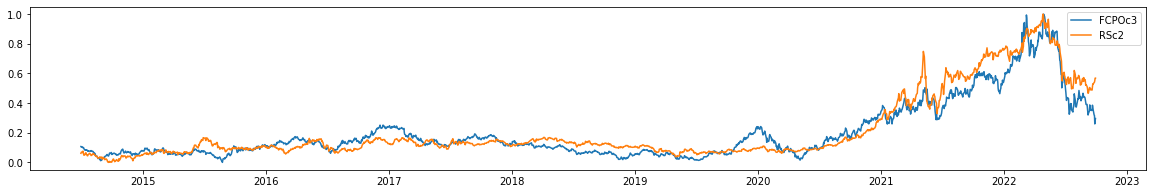

In [55]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df_train,
    id_column="ric",
    timestamp_column="ds",
)

plt.figure(figsize=(20, 3))
print(train_data.head())
for ric in ["FCPOc3", "RSc2"]:
    plt.plot(train_data.loc[ric]['y'], label=ric)
plt.legend()

                        high       low      open         y
item_id timestamp                                         
BOc1    2022-10-03  0.630642  0.633881  0.618437  0.638470
        2022-10-04  0.654792  0.677319  0.662088  0.665142
        2022-10-05  0.657057  0.659479  0.666819  0.671087
        2022-10-06  0.664906  0.668942  0.667277  0.680994
        2022-10-07  0.683774  0.710673  0.693987  0.687243


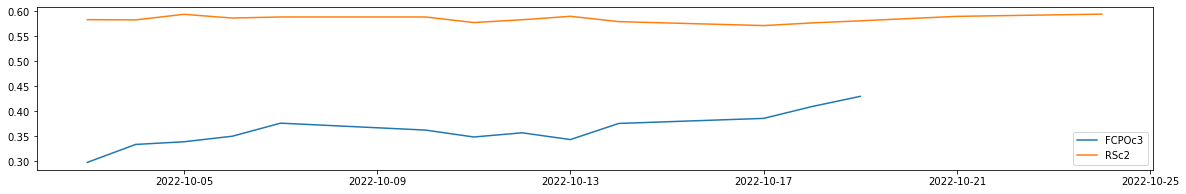

In [54]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="ric",
    timestamp_column="ds",
)

plt.figure(figsize=(20, 3))
print(test_data.head())
for ric in ["FCPOc3", "RSc2"]:
    plt.plot(test_data.loc[ric]['y'], label=ric)
plt.legend()

In [120]:
print(train_data.loc["FCPOc3"]["y"].index.min(), '~', train_data.loc["FCPOc3"]["y"].index.max())

2014-07-02 00:00:00 ~ 2022-09-30 00:00:00


### (2) 모델 검증을 위한 step별로 밟기 위한 데이터 셋 나누기

In [48]:
train_data = train_data.sort_index(ascending=True)#이거 안해주면 UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [1], lexsort depth 0'

prediction_length = 30

train_data_01, test_data_01 = train_data.split_by_time(pd.Timestamp(2022,9,1))
train_data_02, test_data_02 = train_data_01.split_by_time(pd.Timestamp(2022,8,1))
train_data_03, test_data_03 = train_data_02.split_by_time(pd.Timestamp(2022,7,1))
train_data_04, test_data_04 = train_data_03.split_by_time(pd.Timestamp(2022,6,1))
train_data_05, test_data_05 = train_data_04.split_by_time(pd.Timestamp(2022,5,1))


In [130]:
print('Validation dataset Sep')
print('Train:\t',train_data_01.loc["FCPOc3"]["y"].index.min(),'~',train_data_01.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_01.loc["FCPOc3"]["y"].index.min(),'~',test_data_01.loc["FCPOc3"]["y"].index.max())
print('Validation dataset Aug')
print('Train:\t',train_data_02.loc["FCPOc3"]["y"].index.min(),'~',train_data_02.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_02.loc["FCPOc3"]["y"].index.min(),'~',test_data_02.loc["FCPOc3"]["y"].index.max())
print('Validation dataset Jul')
print('Train:\t',train_data_03.loc["FCPOc3"]["y"].index.min(),'~',train_data_03.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_03.loc["FCPOc3"]["y"].index.min(),'~',test_data_03.loc["FCPOc3"]["y"].index.max())
print('Validation dataset Jun')
print('Train:\t',train_data_04.loc["FCPOc3"]["y"].index.min(),'~',train_data_04.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_04.loc["FCPOc3"]["y"].index.min(),'~',test_data_04.loc["FCPOc3"]["y"].index.max())
print('Validation dataset May')
print('Train:\t',train_data_04.loc["FCPOc3"]["y"].index.min(),'~',train_data_05.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_04.loc["FCPOc3"]["y"].index.min(),'~',test_data_05.loc["FCPOc3"]["y"].index.max())


Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-08-31 00:00:00
Test:	 2022-09-01 00:00:00 ~ 2022-09-30 00:00:00
Validation dataset Aug
Train:	 2014-07-02 00:00:00 ~ 2022-07-29 00:00:00
Test:	 2022-08-01 00:00:00 ~ 2022-08-31 00:00:00
Validation dataset Jul
Train:	 2014-07-02 00:00:00 ~ 2022-06-30 00:00:00
Test:	 2022-07-01 00:00:00 ~ 2022-07-29 00:00:00
Validation dataset Jun
Train:	 2014-07-02 00:00:00 ~ 2022-05-31 00:00:00
Test:	 2022-06-01 00:00:00 ~ 2022-06-30 00:00:00
Validation dataset May
Train:	 2014-07-02 00:00:00 ~ 2022-04-29 00:00:00
Test:	 2022-06-01 00:00:00 ~ 2022-05-31 00:00:00


### (3) Model training for each data set

In [131]:
print('Validation dataset Sep')
print('Train:\t',train_data_01.loc["FCPOc3"]["y"].index.min(),'~',train_data_01.loc["FCPOc3"]["y"].index.max())
print('Test:\t',test_data_01.loc["FCPOc3"]["y"].index.min(),'~',test_data_01.loc["FCPOc3"]["y"].index.max())

Validation dataset Sep
Train:	 2014-07-02 00:00:00 ~ 2022-08-31 00:00:00
Test:	 2022-09-01 00:00:00 ~ 2022-09-30 00:00:00


In [136]:
len(test_data_01.loc["FCPOc3"]["y"])

22

In [187]:
val01_model_path = "model/autogluon-FCPOc3-t1-val01({}-{})".format(train_data_01.loc["FCPOc3"]["y"].index.min().strftime('%Y%m%d'),
                                                                   train_data_01.loc["FCPOc3"]["y"].index.max().strftime('%Y%m%d'))
prediction_length = 30

In [189]:
val01_model_path

'model/autogluon-FCPOc3-t1-val01(20140702-20220831)'

In [191]:
%%time
predictor_val01 = TimeSeriesPredictor(
    path = val01_model_path,
    target ='y',
    prediction_length = prediction_length,
    eval_metric = "MAPE",
)
predictor_val01.fit(
    train_data=train_data_01,
    presets="low_quality"
)

Learner random seed set to 0
presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 30,
 'target_column': 'y',
 'time_limit': None}
Provided training data set with 215166 rows, 101 items. Average time series length is 2130.3564356435645.
Training artifacts will be saved to: /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val01(20140702-20220831)
Provided columns ['high', 'low', 'open'] will not be used.
Validation data is None, will hold the last prediction_length 30 time steps out to use as validation set.
AutoGluon will save models to model/autogluon-FCPOc3-t1-val01(20140702-20220831)/

Starting training. Start time is 2022-10-27 14:54:27
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'ARIMA', 'Transfor

CPU times: user 4min 55s, sys: 1.97 s, total: 4min 57s
Wall time: 2min 56s


In [193]:
%%time
predictor_val01_lb = predictor_val01.leaderboard(test_data_01, silent=True)
predictor_val01_lb.to_csv(os.path.join(os.getcwd(),val01_model_path,'leaderboard.csv'))

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Cannot score with model AutoETS. An error occurred: division by zero
Cannot score with model SimpleFeedForward. An error occurred: division by zero
Cannot score with model DeepAR. An error occurred: division by zero
Cannot score with model ARIMA. An error occurred: division by zero
Cannot score with model Transformer. An error occurred: division by zero
Cannot score with model WeightedEnsemble. An error occurred: division by zero


CPU times: user 1.31 s, sys: 52 ms, total: 1.36 s
Wall time: 1.35 s


In [216]:
%%time
predictions_val01_model01 = predictor_val01.predict(data = train_data_01,
                                                    model = predictor_val01_lb['model'][0])

Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


CPU times: user 1min 28s, sys: 212 ms, total: 1min 28s
Wall time: 1min 15s


In [217]:
val01_result = pd.merge(test_data_01.loc['FCPOc3']['y'], predictions_val01_model01.loc['FCPOc3'], 
                        left_index=True, right_index=True, 
                        how='left')

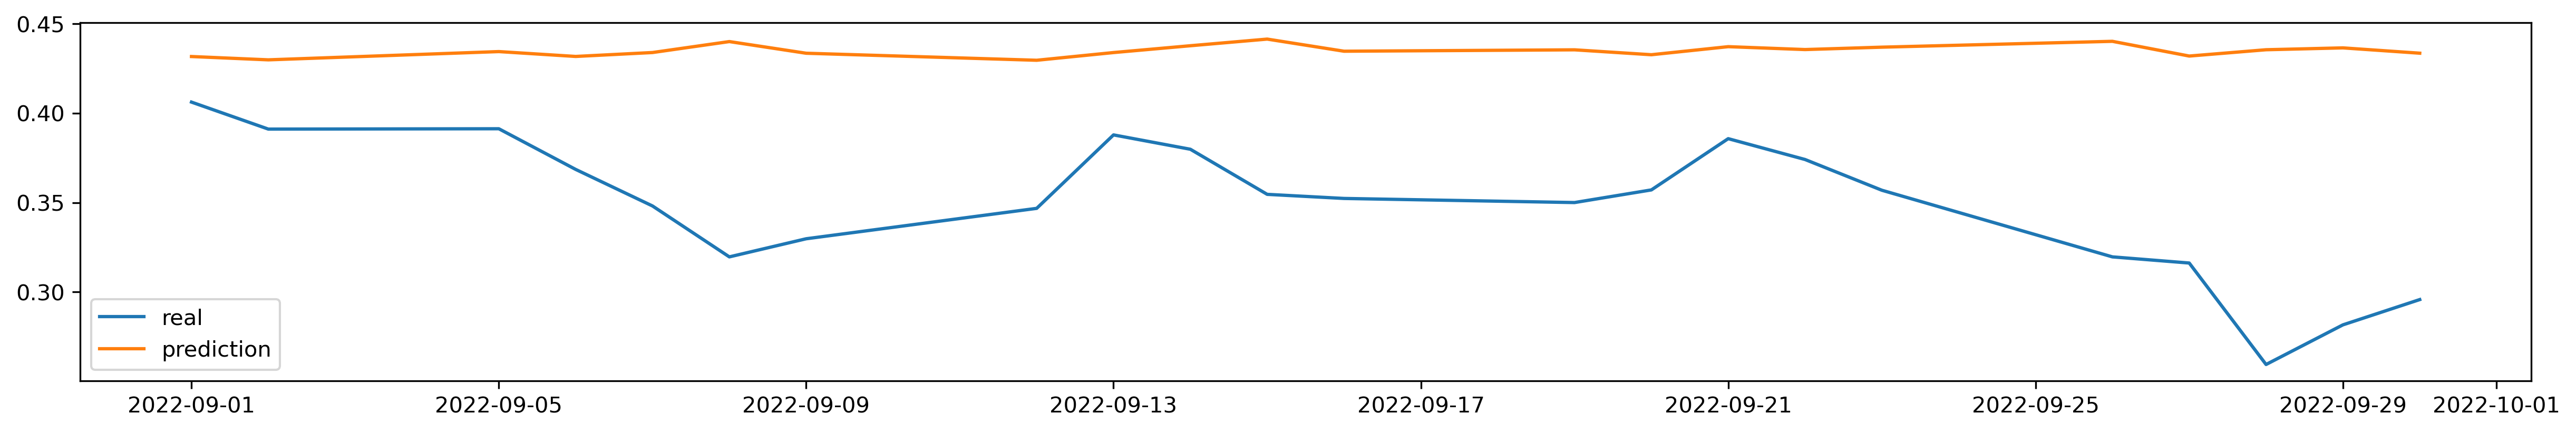

In [221]:
plt.figure(figsize=(20, 3),dpi=300)
plt.plot(val01_result['y'], label='real')
plt.plot(val01_result['mean'], label='prediction')
plt.legend()

In [222]:
val01_result.to_csv(os.path.join(os.getcwd(),val01_model_path,'prediction.csv'))

In [223]:
import os
from tqdm import tqdm

def upload_folder_to_s3(s3_client, s3bucket, input_dir, s3_path):
    pbar = tqdm(os.walk(input_dir))
    for path, subdirs, files in pbar:
        for file in files:
            dest_path = path.replace(input_dir, "").replace(os.sep, '/')
            s3_file = f'{s3_path}/{dest_path}/{file}'.replace('//', '/')
            local_file = os.path.join(path, file)
            s3_client.upload_file(local_file, s3bucket, s3_file)
            pbar.set_description(f'Uploaded {local_file} to {s3_file}')
    print(f"Successfully uploaded {input_dir} to S3 {s3_path}")
    
s3_client = boto3.client('s3', aws_access_key_id=ACCESS_KEY_ID, aws_secret_access_key=ACCESS_SECRET_KEY)
upload_folder_to_s3(s3_client, BUCKET_NAME_USECASE, os.path.join(os.getcwd(),'model'), S3_PATH_TRAIN)

Uploaded /home/ec2-user/SageMaker/palm-oil-price-forecast/model/autogluon-FCPOc3-t1-val01(20140702-20220812)/utils/data/val.pkl to trained-model/autogluon-FCPOc3-t1-val01(20140702-20220812)/utils/data/val.pkl: : 25it [00:05,  4.85it/s]                                                                                      

Successfully uploaded /home/ec2-user/SageMaker/palm-oil-price-forecast/model to S3 trained-model


In [224]:
predictor_val01_lb

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,NaN,-0.090938,NaN,22.162412,57.526312,6
1,Transformer,NaN,-0.100963,NaN,2.438139,5.858733,5
2,SimpleFeedForward,NaN,-0.095750,NaN,0.637415,3.493169,2
3,DeepAR,NaN,-0.096641,NaN,1.427172,9.265490,3
4,AutoETS,NaN,-0.092504,NaN,7.776823,18.029280,1
5,ARIMA,NaN,-0.106740,NaN,11.310034,33.975685,4


In [ ]:
# Specify the model source
model_url = "s3://your-bucket-name/model.tar.gz"

modelpackage_inference_specification =  {
    "InferenceSpecification": {
        "Containers": [
            {
                "Image": '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.2-1',
                "ModelDataUrl": model_url
            }
        ],
        "SupportedContentTypes": [ "text/csv" ],
        "SupportedResponseMIMETypes": [ "text/csv" ],
    }
}

# Alternatively, you can specify the model source like this:
# modelpackage_inference_specification["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]=model_url

create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "Model to detect 3 different types of irises (Setosa, Versicolour, and Virginica)",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

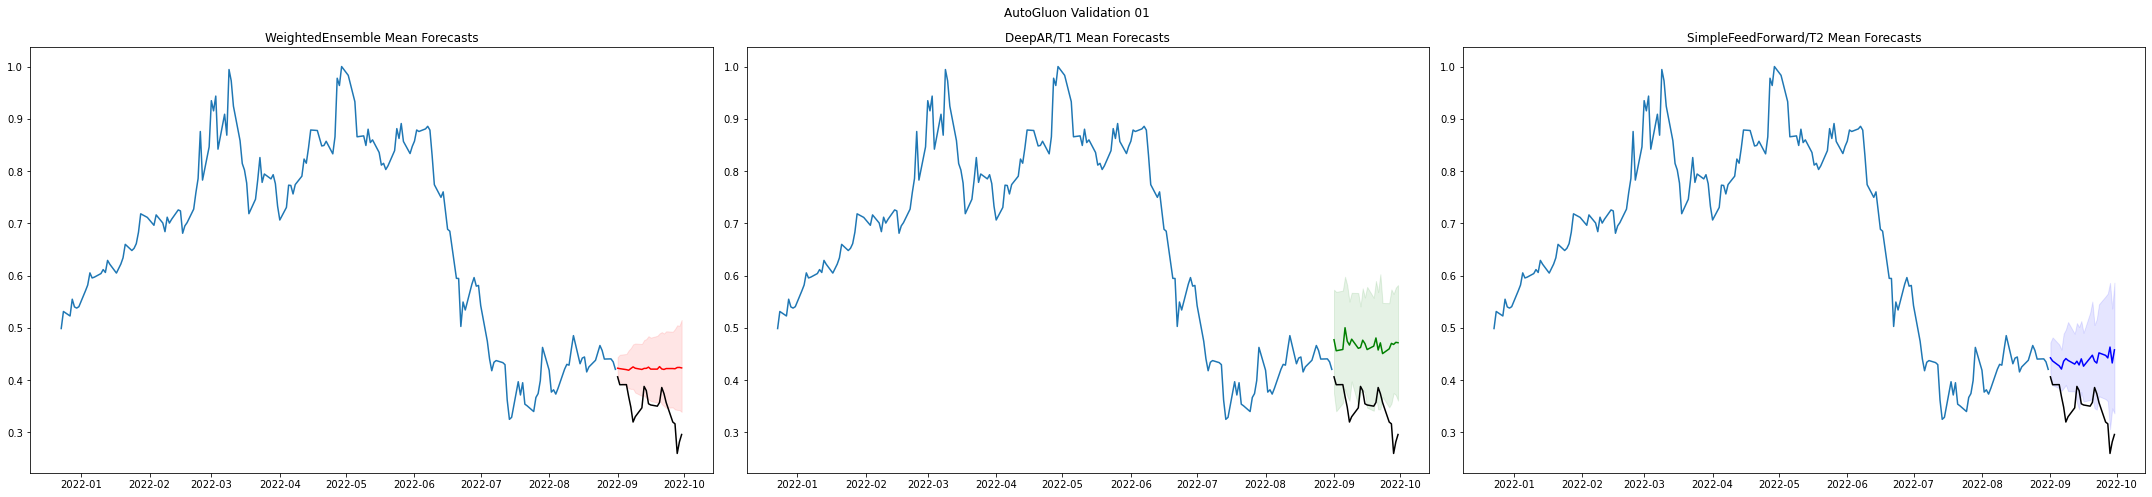

In [144]:
# ytrue = train_data_01.loc['FCPOc3']["y"]
# ypred_model01 = predictions_val01_model01.loc['FCPOc3']
# ypred_model02 = predictions_val01_model02.loc['FCPOc3']
# ypred_model03 = predictions_val01_model03.loc['FCPOc3']

# ytrue_test = test_data_01.loc['FCPOc3']["y"][-prediction_length:]

# fig, axs = plt.subplots(1, 3, figsize=(30, 7))

# fig.suptitle('AutoGluon Validation 01')

# axs[0].plot(ytrue[-180:], label="Training Data")
# axs[0].plot(ytrue_test, label="Actual", color="black")
# axs[0].plot(ypred_model01["mean"], label="Forecasts", color="red")
# axs[0].fill_between(ypred_model01.index, ypred_model01["0.1"], ypred_model01["0.9"], color="red", alpha=0.1)
# axs[0].set_title('WeightedEnsemble Mean Forecasts')

# axs[1].plot(ytrue[-180:], label="Training Data")
# axs[1].plot(ytrue_test, label="Actual", color="black")
# axs[1].plot(ypred_model02["mean"], label="Forecasts", color="green")
# axs[1].fill_between(ypred_model02.index, ypred_model02["0.1"], ypred_model02["0.9"], color="green", alpha=0.1)
# axs[1].set_title('DeepAR/T1 Mean Forecasts')


# axs[2].plot(ytrue[-180:], label="Training Data")
# axs[2].plot(ytrue_test, label="Actual", color="black")
# axs[2].plot(ypred_model03["mean"], label="Forecasts", color="blue")
# axs[2].fill_between(ypred_model03.index, ypred_model03["0.1"], ypred_model03["0.9"], color="blue", alpha=0.1)
# axs[2].set_title('SimpleFeedForward/T2 Mean Forecasts')

# plt.tight_layout()
# plt.show()

In [ ]:
import os
import sys
import boto3

# get an access token, local (from) directory, and S3 (to) directory
# from the command-line
# local_directory, bucket, destination = sys.argv[1:4]
local_directory = os.path.join(os.getcwd(),'model')
bucket = BUCKET_NAME_USECASE
destination = S3_PATH_TRAIN

client = boto3.client('s3')

# enumerate local files recursively
for root, dirs, files in os.walk(local_directory):
    for filename in files:

    # construct the full local path
        local_path = os.path.join(root, filename)

        # construct the full Dropbox path
        relative_path = os.path.relpath(local_path, local_directory)
        s3_path = os.path.join(destination, relative_path)

        # relative_path = os.path.relpath(os.path.join(root, filename))

        print('Searching {} in {}'.format(s3_path, bucket))
        try:
            client.head_object(Bucket=bucket, Key=s3_path)
            print("Path found on S3! Skipping {}...".format(s3_path))

            # try:
                # client.delete_object(Bucket=bucket, Key=s3_path)
            # except:
                # print "Unable to delete %s..." % s3_path
        except:
            print("Uploading {}...".format(s3_path))
            client.upload_file(local_path, bucket, s3_path)

In [ ]:
%%time
predictor_val02 = TimeSeriesPredictor(
    path="model/autogluon-FCPOc3-t1-val02(20140702~20220701)",
    target='y',
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor_val02.fit(
    train_data=train_data_02,
    presets="good_quality"
)

In [ ]:
%%time
predictor_val02.leaderboard(test_data_02, silent=True)

In [ ]:
%%time
predictions_val02_model01 = predictor_val02.predict(data = train_data_02,
                                                             model = 'WeightedEnsemble')
predictions_val02_model02 = predictor_val02.predict(data = train_data_02,
                                                        model = 'Transformer/T1')
predictions_val02_model03 = predictor_val02.predict(data = train_data_02,
                                                   model = 'Transformer/T2')

In [ ]:
ytrue = train_data_02.loc['FCPOc3']["y"]
ypred_model01 = predictions_val02_model01.loc['FCPOc3']
ypred_model02 = predictions_val02_model02.loc['FCPOc3']
ypred_model03 = predictions_val02_model03.loc['FCPOc3']

ytrue_test = test_data_02.loc['FCPOc3']["y"][-prediction_length:]

fig, axs = plt.subplots(1, 3, figsize=(30, 7))

fig.suptitle('AutoGluon Validation 02')

axs[0].plot(ytrue[-180:], label="Training Data")
axs[0].plot(ytrue_test, label="Actual", color="black")
axs[0].plot(ypred_model01["mean"], label="Forecasts", color="red")
axs[0].fill_between(ypred_model01.index, ypred_model01["0.1"], ypred_model01["0.9"], color="red", alpha=0.1)
axs[0].set_title('WeightedEnsemble Mean Forecasts')

axs[1].plot(ytrue[-180:], label="Training Data")
axs[1].plot(ytrue_test, label="Actual", color="black")
axs[1].plot(ypred_model02["mean"], label="Forecasts", color="green")
axs[1].fill_between(ypred_model02.index, ypred_model02["0.1"], ypred_model02["0.9"], color="green", alpha=0.1)
axs[1].set_title('Transformer/T1 Mean Forecasts')


axs[2].plot(ytrue[-180:], label="Training Data")
axs[2].plot(ytrue_test, label="Actual", color="black")
axs[2].plot(ypred_model03["mean"], label="Forecasts", color="blue")
axs[2].fill_between(ypred_model03.index, ypred_model03["0.1"], ypred_model03["0.9"], color="blue", alpha=0.1)
axs[2].set_title('Transformer/T2 Mean Forecasts')


fig.supxlabel('Date')
fig.supylabel('Price(MYR)')
plt.tight_layout()
plt.show()

In [ ]:
%%time
predictor_val03 = TimeSeriesPredictor(
    path="model/autogluon-FCPOc3-t1-val03(20140702~20220520)",
    target='y',
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor_val03.fit(
    train_data=train_data_03,
    presets="good_quality"
)

In [ ]:
%%time
predictor_val03.leaderboard(test_data_03, silent=True)

In [ ]:
%%time
predictions_val03_model01 = predictor_val03.predict(data = train_data_03,
                                                             model = 'ARIMA/T1')
predictions_val03_model02 = predictor_val03.predict(data = train_data_03,
                                                        model = 'Transformer/T1')
predictions_val03_model03 = predictor_val03.predict(data = train_data_03,
                                                   model = 'DeepAR/T1')

In [ ]:
ytrue = train_data_03.loc['FCPOc3']["y"]
ypred_model01 = predictions_val03_model01.loc['FCPOc3']
ypred_model02 = predictions_val03_model02.loc['FCPOc3']
ypred_model03 = predictions_val03_model03.loc['FCPOc3']

ytrue_test = test_data_03.loc['FCPOc3']["y"][-prediction_length:]

fig, axs = plt.subplots(1, 3, figsize=(30, 7))

fig.suptitle('AutoGluon Validation 03')

axs[0].plot(ytrue[-180:], label="Training Data")
axs[0].plot(ytrue_test, label="Actual", color="black")
axs[0].plot(ypred_model01["mean"], label="Forecasts", color="red")
axs[0].fill_between(ypred_model01.index, ypred_model01["0.1"], ypred_model01["0.9"], color="red", alpha=0.1)
axs[0].set_title('ARIMA/T1 Mean Forecasts')

axs[1].plot(ytrue[-180:], label="Training Data")
axs[1].plot(ytrue_test, label="Actual", color="black")
axs[1].plot(ypred_model02["mean"], label="Forecasts", color="green")
axs[1].fill_between(ypred_model02.index, ypred_model02["0.1"], ypred_model02["0.9"], color="green", alpha=0.1)
axs[1].set_title('Transformer/T1 Mean Forecasts')


axs[2].plot(ytrue[-180:], label="Training Data")
axs[2].plot(ytrue_test, label="Actual", color="black")
axs[2].plot(ypred_model03["mean"], label="Forecasts", color="blue")
axs[2].fill_between(ypred_model03.index, ypred_model03["0.1"], ypred_model03["0.9"], color="blue", alpha=0.1)
axs[2].set_title('DeepAR/T1 Mean Forecasts')


fig.supxlabel('Date')
fig.supylabel('Price(MYR)')
plt.tight_layout()
plt.show()

In [ ]:
%%time
predictions_val03_model04 = predictor_val03.predict(data = train_data_03,
                                                             model = 'AutoETS/T1')
predictions_val03_model05 = predictor_val03.predict(data = train_data_03,
                                                        model = 'WeightedEnsemble')
predictions_val03_model06 = predictor_val03.predict(data = train_data_03,
                                                   model = 'DeepAR/T2')

In [ ]:
ytrue = train_data_03.loc['FCPOc3']["y"]
ypred_model01 = predictions_val03_model04.loc['FCPOc3']
ypred_model02 = predictions_val03_model05.loc['FCPOc3']
ypred_model03 = predictions_val03_model06.loc['FCPOc3']

ytrue_test = test_data_03.loc['FCPOc3']["y"][-prediction_length:]

fig, axs = plt.subplots(1, 3, figsize=(30, 7))

fig.suptitle('AutoGluon Validation 03')

axs[0].plot(ytrue[-180:], label="Training Data")
axs[0].plot(ytrue_test, label="Actual", color="black")
axs[0].plot(ypred_model01["mean"], label="Forecasts", color="red")
axs[0].fill_between(ypred_model01.index, ypred_model01["0.1"], ypred_model01["0.9"], color="red", alpha=0.1)
axs[0].set_title('AutoETS/T1 Mean Forecasts')

axs[1].plot(ytrue[-180:], label="Training Data")
axs[1].plot(ytrue_test, label="Actual", color="black")
axs[1].plot(ypred_model02["mean"], label="Forecasts", color="green")
axs[1].fill_between(ypred_model02.index, ypred_model02["0.1"], ypred_model02["0.9"], color="green", alpha=0.1)
axs[1].set_title('WeightedEnsemble Mean Forecasts')


axs[2].plot(ytrue[-180:], label="Training Data")
axs[2].plot(ytrue_test, label="Actual", color="black")
axs[2].plot(ypred_model03["mean"], label="Forecasts", color="blue")
axs[2].fill_between(ypred_model03.index, ypred_model03["0.1"], ypred_model03["0.9"], color="blue", alpha=0.1)
axs[2].set_title('DeepAR/T2 Mean Forecasts')


fig.supxlabel('Date')
fig.supylabel('Price(MYR)')
plt.tight_layout()
plt.show()

In [ ]:
%%time
predictor_val04 = TimeSeriesPredictor(
    path="model/autogluon-FCPOc3-t1-val04(20140702~20220408)",
    target='y',
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor_val04.fit(
    train_data=train_data_04,
    presets="good_quality"
)

In [ ]:
%%time
predictor_val04.leaderboard(test_data_04, silent=True)

In [ ]:
%%time
predictions_val04_model01 = predictor_val04.predict(data = train_data_04,
                                                             model = 'AutoETS/T1')
predictions_val04_model02 = predictor_val04.predict(data = train_data_04,
                                                        model = 'ARIMA/T1')
predictions_val04_model03 = predictor_val04.predict(data = train_data_04,
                                                   model = 'WeightedEnsemble')

In [ ]:
ytrue = train_data_04.loc['FCPOc3']["y"]
ypred_model01 = predictions_val04_model01.loc['FCPOc3']
ypred_model02 = predictions_val04_model02.loc['FCPOc3']
ypred_model03 = predictions_val04_model03.loc['FCPOc3']

ytrue_test = test_data_04.loc['FCPOc3']["y"][-prediction_length:]

fig, axs = plt.subplots(1, 3, figsize=(30, 7))

fig.suptitle('AutoGluon Validation 04')

axs[0].plot(ytrue[-180:], label="Training Data")
axs[0].plot(ytrue_test, label="Actual", color="black")
axs[0].plot(ypred_model01["mean"], label="Forecasts", color="red")
axs[0].fill_between(ypred_model01.index, ypred_model01["0.1"], ypred_model01["0.9"], color="red", alpha=0.1)
axs[0].set_title('AutoETS Mean Forecasts')

axs[1].plot(ytrue[-180:], label="Training Data")
axs[1].plot(ytrue_test, label="Actual", color="black")
axs[1].plot(ypred_model02["mean"], label="Forecasts", color="green")
axs[1].fill_between(ypred_model02.index, ypred_model02["0.1"], ypred_model02["0.9"], color="green", alpha=0.1)
axs[1].set_title('ARIMA/T1 Mean Forecasts')


axs[2].plot(ytrue[-180:], label="Training Data")
axs[2].plot(ytrue_test, label="Actual", color="black")
axs[2].plot(ypred_model03["mean"], label="Forecasts", color="blue")
axs[2].fill_between(ypred_model03.index, ypred_model03["0.1"], ypred_model03["0.9"], color="blue", alpha=0.1)
axs[2].set_title('WeightedEnsemble Mean Forecasts')


fig.supxlabel('Date')
fig.supylabel('Price(MYR)')
plt.tight_layout()
plt.show()

In [ ]:
%%time
predictor_val05 = TimeSeriesPredictor(
    path="model/autogluon-FCPOc3-t1-val05(20140702~20220225)",
    target='y',
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor_val05.fit(
    train_data=train_data_05,
    presets="good_quality"
)

In [ ]:
%%time
predictor_val05.leaderboard(test_data_05, silent=True)

In [ ]:
%%time
predictions_val05_model01 = predictor_val05.predict(data = train_data_05,
                                                             model = 'Transformer/T1')
predictions_val05_model02 = predictor_val05.predict(data = train_data_05,
                                                        model = 'WeightedEnsemble')
predictions_val05_model03 = predictor_val05.predict(data = train_data_05,
                                                   model = 'Transformer/T2')

In [ ]:
ytrue = train_data_05.loc['FCPOc3']["y"]
ypred_model01 = predictions_val05_model01.loc['FCPOc3']
ypred_model02 = predictions_val05_model02.loc['FCPOc3']
ypred_model03 = predictions_val05_model03.loc['FCPOc3']

ytrue_test = test_data_05.loc['FCPOc3']["y"][-prediction_length:]

fig, axs = plt.subplots(1, 3, figsize=(30, 7))

fig.suptitle('AutoGluon Validation 05')

axs[0].plot(ytrue[-120:], label="Training Data")
axs[0].plot(ytrue_test, label="Actual", color="black")
axs[0].plot(ypred_model01["mean"], label="Forecasts", color="red")
axs[0].fill_between(ypred_model01.index, ypred_model01["0.1"], ypred_model01["0.9"], color="red", alpha=0.1)
axs[0].set_title('Transformer/T1 Mean Forecasts')

axs[1].plot(ytrue[-60:], label="Training Data")
axs[1].plot(ytrue_test, label="Actual", color="black")
axs[1].plot(ypred_model02["mean"], label="Forecasts", color="green")
axs[1].fill_between(ypred_model02.index, ypred_model02["0.1"], ypred_model02["0.9"], color="green", alpha=0.1)
axs[1].set_title('WeightedEnsemble Mean Forecasts')


axs[2].plot(ytrue[-60:], label="Training Data")
axs[2].plot(ytrue_test, label="Actual", color="black")
axs[2].plot(ypred_model03["mean"], label="Forecasts", color="blue")
axs[2].fill_between(ypred_model03.index, ypred_model03["0.1"], ypred_model03["0.9"], color="blue", alpha=0.1)
axs[2].set_title('Transformer/T2 Mean Forecasts')


fig.supxlabel('Date')
fig.supylabel('Price(MYR)')
plt.tight_layout()
plt.show()

## n) 마지막! 스크립트화 하자

### (1) 참고자료(1): 유동님 Github
- Training using the pre-processed data 부터 시작
- 여기서는 Linear로 진행했기 때문에 우선 돌아가는지 테스트차 categorical 변수 빼고 진행해보자.

In [59]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

sklearn = SKLearn(
    entry_point="train.py",
    framework_version="1.0-1",
    instance_type="ml.m5.xlarge",
    role=role

)

```python
%%writefile train.py

import os

import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.externals import joblib
import joblib

if __name__ == "__main__":
    training_data_directory = "/opt/ml/input/data/train"
    train_features_data = os.path.join(training_data_directory, "train_features.csv")
    train_labels_data = os.path.join(training_data_directory, "train_labels.csv")
    print("Reading input data")
    X_train = pd.read_csv(train_features_data, header=None)
    y_train = pd.read_csv(train_labels_data, header=None)

    model = LogisticRegression(class_weight="balanced", solver="lbfgs")
    print("Training LR model")
    model.fit(X_train, y_train)
    model_output_directory = os.path.join("/opt/ml/model", "model.joblib")
    print("Saving model to {}".format(model_output_directory))
    joblib.dump(model, model_output_directory)
```

In [73]:
%%writefile train.py

import os

import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.externals import joblib
import joblib


if __name__ == "__main__":
    training_data_directory = "/opt/ml/input/data/train"
    train_path = os.path.join(training_data_directory, 'train.csv')#"train_features.csv")
    # train_labels_data = os.path.join(training_data_directory, "train_labels.csv")
    print("Reading input data")
    df_train = pd.read_csv(train_path)
    df_train = df_train[df_train['ric'] == 'FCPOc3']
    print(df_train)
    X_train = df_train[['ds','high','low','open']]
    y_train = df_train[['ds','y']]

    model = LogisticRegression(class_weight="balanced", solver="lbfgs")
    print("Training LR model")
    model.fit(X_train, y_train)
    model_output_directory = os.path.join("/opt/ml/model", "model.joblib")
    print("Saving model to {}".format(model_output_directory))
    joblib.dump(model, model_output_directory)

Overwriting train.py


train.py 트레이닝 스크립트는 트레이닝 데이터를 사용하여 logistic regression 모델을 만들고, 다음 디렉토리에 /opt/ml/model 모델을 저장합니다. Amazon SageMaker 는 tar 파일을 만들고다름과 같은 이름으로 model.tar.gz S3 에 업로드 합니다.

만들어진 train.py 스트립트를 사용하여 모델을 트레이닝 합니다.

In [74]:
sklearn.fit({"train": preprocessed_training_data})
training_job_description = sklearn.jobs[-1].describe()
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)

2022-10-27 13:00:33 Starting - Starting the training job...
2022-10-27 13:00:59 Starting - Preparing the instances for trainingProfilerReport-1666875633: InProgress
......
2022-10-27 13:02:02 Downloading - Downloading input data...
2022-10-27 13:02:22 Training - Downloading the training image.....2022-10-27 13:03:10,517 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-10-27 13:03:10,520 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-27 13:03:10,528 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-10-27 13:03:10,853 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-27 13:03:10,867 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-27 13:03:10,878 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-27 13:03:10,887 sagemaker-training-toolkit INFO     Inv

UnexpectedStatusException: Error for Training job sagemaker-scikit-learn-2022-10-27-13-00-33-321: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_containers/_trainer.py", line 84, in train
    entrypoint()
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_sklearn_container/training.py", line 39, in main
    train(environment.Environment())
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_sklearn_container/training.py", line 31, in train
    entry_point.run(uri=training_environment.module_dir,
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_training/entry_point.py", line 99, in run
    return runner.get(runner_type, user_entry_point, args, env_vars, extra_opts).run(
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_training/process.py", line 286, in run
    process = check_error(
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_training/process.py", line 204, in check_error
    raise error_class(
sagemaker_training.errors.ExecuteUserScriptError: ExecuteUserScriptError:
ExitCode 1
Error

### (2) 참고자료(2): DeepAR

In [ ]:
%%writefile train.py

import argparse
import os
from pprint import pprint

import yaml
from autogluon.tabular import TabularDataset, TabularPredictor


def get_input_path(path):
    file = os.listdir(path)[0]
    if len(os.listdir(path)) > 1:
        print(f"WARN: more than one file is found in {channel} directory")
    print(f"Using {file}")
    filename = f"{path}/{file}"
    return filename


def get_env_if_present(name):
    result = None
    if name in os.environ:
        result = os.environ[name]
    return result


if __name__ == "__main__":
    # Disable Autotune
    os.environ["MXNET_CUDNN_AUTOTUNE_DEFAULT"] = "0"

    # ------------------------------------------------------------ Arguments parsing
    print("Starting AG")
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument(
        "--output-data-dir", type=str, default=get_env_if_present("SM_OUTPUT_DATA_DIR")
    )
    parser.add_argument("--model-dir", type=str, default=get_env_if_present("SM_MODEL_DIR"))
    parser.add_argument("--n_gpus", type=str, default=get_env_if_present("SM_NUM_GPUS"))
    parser.add_argument("--training_dir", type=str, default=get_env_if_present("SM_CHANNEL_TRAIN"))
    parser.add_argument(
        "--test_dir", type=str, required=False, default=get_env_if_present("SM_CHANNEL_TEST")
    )
    parser.add_argument("--ag_config", type=str, default=get_env_if_present("SM_CHANNEL_CONFIG"))

    args, _ = parser.parse_known_args()

    print(f"Args: {args}")

    # See SageMaker-specific environment variables: https://sagemaker.readthedocs.io/en/stable/overview.html#prepare-a-training-script
    os.makedirs(args.output_data_dir, mode=0o777, exist_ok=True)

    config_file = get_input_path(args.ag_config)
    with open(config_file) as f:
        config = yaml.safe_load(f)  # AutoGluon-specific config

    if args.n_gpus:
        config["num_gpus"] = int(args.n_gpus)

    print("Running training job with the config:")
    pprint(config)

    # ---------------------------------------------------------------- Training

    train_file = get_input_path(args.training_dir)
    train_data = TabularDataset(train_file)

    ag_predictor_args = config["ag_predictor_args"]
    ag_predictor_args["path"] = args.model_dir
    ag_fit_args = config["ag_fit_args"]

    predictor = TabularPredictor(**ag_predictor_args).fit(train_data, **ag_fit_args)

    # --------------------------------------------------------------- Inference

    if args.test_dir:
        test_file = get_input_path(args.test_dir)
        test_data = TabularDataset(test_file)

        # Predictions
        y_pred_proba = predictor.predict_proba(test_data)
        if config.get("output_prediction_format", "csv") == "parquet":
            y_pred_proba.to_parquet(f"{args.output_data_dir}/predictions.parquet")
        else:
            y_pred_proba.to_csv(f"{args.output_data_dir}/predictions.csv")

        # Leaderboard
        if config.get("leaderboard", False):
            lb = predictor.leaderboard(test_data, silent=False)
            lb.to_csv(f"{args.output_data_dir}/leaderboard.csv")

        # Feature importance
        if config.get("feature_importance", False):
            feature_importance = predictor.feature_importance(test_data)
            feature_importance.to_csv(f"{args.output_data_dir}/feature_importance.csv")
    else:
        if config.get("leaderboard", False):
            lb = predictor.leaderboard(silent=False)
            lb.to_csv(f"{args.output_data_dir}/leaderboard.csv")

In [105]:
%%writefile config-med.yaml
# AutoGluon Predictor constructor arguments
# - see https://github.com/awslabs/autogluon/blob/ef3a5312dc2eaa0c6afde042d671860ac42cbafb/tabular/src/autogluon/tabular/predictor/predictor.py#L51-L159
ag_predictor_args:
    eval_metric: 'MAPE' #roc_auc
    #target: 'y'
    #prediction_length = 30
    #path: "model/autogluon-FCPOc3-t1-val01(20140702-20220812)"
    
# AutoGluon Predictor.fit arguments
# - see https://github.com/awslabs/autogluon/blob/ef3a5312dc2eaa0c6afde042d671860ac42cbafb/tabular/src/autogluon/tabular/predictor/predictor.py#L280-L651
ag_fit_args:
    presets: 'good_quality' #presets: "medium_quality_faster_train"
    #num_bag_folds: 2
    #num_bag_sets: 1
    #num_stack_levels: 0

output_prediction_format: csv  # predictions output format: csv or parquet
feature_importance: true       # calculate and save feature importance if true
leaderboard: true              # save leaderboard output if true

Writing config-med.yaml


In [106]:
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)

ModuleNotFoundError: No module named 'ag_model'

In [98]:
import sagemaker

# Helper wrappers referred earlier
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)
from sagemaker import utils

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_prefix}/output/"

366743142698.dkr.ecr.ap-northeast-2.amazonaws.com/sagemaker-xgboost:1.2-1


In [ ]:
ag = AutoGluonTraining(
    role=role,
    entry_point="scripts/tabular_train.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.4",
    py_version="py38",
    base_job_name="autogluon-tabular-train",
)

In [ ]:
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "train.csv"), key_prefix=s3_prefix
)
eval_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "test.csv"), key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path=os.path.join("config", "config-med.yaml"), key_prefix=s3_prefix
)

job_name = utils.unique_name_from_base("test-autogluon-image")
ag.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)

---

In [ ]:
boto_sesssion = boto3.Session(ACCESS_KEY_ID,
                              ACCESS_SECRET_KEY)
# region = re.region_name

session = sagemaker.Session(boto_session = boto_session)
s3_session = boto_sesssion.resource('s3')
bucket = s3_session.Bucket(BUCKET_NAME_USECASE)
    # S3_PATH_STAGE = keychain['S3_PATH_STAGE']
    # S3_PATH_GOLDEN = keychain['S3_PATH_GOLDEN']
    # S3_PATH_TRAIN = keychain['S3_PATH_TRAIN']
    # S3_PATH_log = keychain['S3_PATH_LOG']
bucket = s3_resource.Bucket(bucket_name)
timestamp_suffix = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

prefix = 'sagemaker/link-prediction-developer-guide-' + timestamp_suffix

role = os.environ["SAGEMAKER_ROLE"]

sm = boto_session.client(service_name='sagemaker',region_name=region)

In [221]:
import os
import sagemaker
import tensorflow as tf

sess = sagemaker.Session()
bucket = sess.default_bucket() 

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, existok=True)

raw_dir = os.path.join(os.getcwd(), 'data/raw')
os.makedirs(raw_dir, exist_ok=True)

TypeError: makedirs() got an unexpected keyword argument 'existok'

1. SageMaker Processing을 이용한 데이터 전처리(정제)
**워크플로우**
   1. 필요한 데이터셋 불러오기
   2. np.save()로 배열을 NumPy format의 바이너리 파일로 저장하기 (Save a single array to a binary file in NumPy format)
   3. S3에 업로드
   4. SageMaker Processing을 이용한 데이터 전처리   
   5. 학습과 테스트를 위해 레이블 생성 & 저장.
   
**SageMaker Processing?**
- SageMaker 노트북 서버와 분리된 독립적 환경에서 테라바이트 수준의 데이터를 변환처리 가능.   
- 일반적으로 Prototyping 작업에 사용되는 노트북은 SageMaker 일반 사양에서 실행하며 전처리, 학습, 모델 호스팅과 같은 작업은 강력한 사양의 인스턴스에서 실행.    
- SageMaker Processing은 Scikit-learn이 기본 탑재되어 있으며 **Bring Your Own Container** 옵션으로 다양한 데이터 정제 작업을 별도 독립된 환경에서 실행 가능

In [ ]:
import numpy as np
from tensorflow.python.keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler
import glob

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

np.save(os.path.join(raw_dir, 'x_train.npy'), x_train)
np.save(os.path.join(raw_dir, 'x_test.npy'), x_test)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test)

s3_prefix = 'tf-2-workflow'
rawdata_s3_prefix = '{}/data/raw'.format(s3_prefix)
raw_s3 = sess.upload_data(path='./data/raw/', key_prefix=rawdata_s3_prefix)
print(raw_s3)

In [ ]:
import os
os.listdir('{}'.format('./data/raw'))

In [ ]:
glob.glob('{}/*.npy'.format('./data/raw'))

In [ ]:
%%writefile preprocessing.py

import glob
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

if __name__=='__main__':
    input_files = glob.glob('{}/*.npy'.format('/opt/ml/processing/input')) # 입력파일 로드 경로 지정
    print('\nINPUT FILE LIST: \n{}\n'.format(input_files))
    scaler = StandardScaler()
    for file in input_files:
        raw = np.load(file)
        transformed = scaler.fit_transform(raw)
        if 'train' in file:
            output_path = os.path.join('/opt/ml/processing/train', 'x_train.npy') # 출력파일 저장될 경로 지정
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TRAINING DATA FILE\n')
        else: 
            output_path = os.path.join('/opt/ml/processing/test', 'x_test.npy') # 출력파일 저장될 경로 지정
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TEST DATA FILE\n')

SKLearnProcessor 오브젝트(for SageMaker Processing 작업)  
- 오브젝트 생성시 사용할 인스턴스 타입과 몇개의 인스턴스를 사용할 지 정의할 수 있다. 
- 보스턴 집값 데이터셋은 매우 작은 데이터이지만 SageMaker Processing의 클러스터링 작업이 어떻게 실행하는지 보기 위해 두 개의 인스턴스를 사용.

In [ ]:
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

processing_tags = [{'Key': 'cost-center',
                    'Value': 'TF2WorkflowProcessing'}]

sklearn_processor1 = SKLearnProcessor(framework_version='0.23-1',
                                     role=get_execution_role(),
                                     instance_type='ml.m5.xlarge',
                                     instance_count=2,
                                     tags=processing_tags)

- 이제 데이터 파일을 인스턴스에 동일하게 분산하기 위해
- ProcessingInput 오브젝트에 SharedByS3Key 분산타입을 지정. 
- 이때, 만약 n개의 인스턴스를 선언했다면 각 인스턴스는 1/n 파일을 S3로부터 받게 될 것. 
- 실행에는 3분 정도 소요되며 대부분 Cluster를 구성하는 시간이 차지함. 
- 작업종료시 Cluster는 SageMaker에 의해 자동으로 삭제될 예정

In [ ]:
'{}/train'.format(output_destination)

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from time import gmtime, strftime 

processing_job_name = "tf-2-workflow-{}".format(strftime("%d-%H-%M-%S", gmtime()))

output_destination = 's3://{}/{}/data'.format(bucket, s3_prefix)

sklearn_processor.run(code='preprocessing.py',
                      job_name=processing_job_name,
                      inputs=[ProcessingInput(
                        source=raw_s3,
                        destination='/opt/ml/processing/input',
                        s3_data_distribution_type='ShardedByS3Key')],
                      outputs=[ProcessingOutput(output_name='train',
                                                destination='{}/train'.format(output_destination),
                                                source='/opt/ml/processing/train'),
                               ProcessingOutput(output_name='test',
                                                destination='{}/test'.format(output_destination),
                                                source='/opt/ml/processing/test')])

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

SageMaker Processing 작업의 출력 로그 
- 두가지 색상으로 각 인스턴스의 로그를 볼 수 있다.
- 각 인스턴스가 서로 다른 파일을 받은 것을 확인할 수 있다.
- 만약 ShardedByS3Key 분산타입을 사용하지 않았다면 각 인스턴스는 복사본을 받음. 
- 대부분의 stateless 데이터 전처리(정제)에서는 n개의 인스턴스에 동일하게 파일을 분산함으로써 대략 n만큼 작업속도를 향상시킬 수 있다.
 
본 작업결과를 로컬에 저장 후, 다음으로 Prototype 훈련과 추론을 작성하자.

In [ ]:
train_in_s3 = '{}/train/x_train.npy'.format(output_destination)
test_in_s3 = '{}/test/x_test.npy'.format(output_destination)
!aws s3 cp {train_in_s3} ./data/train/x_train.npy
!aws s3 cp {test_in_s3} ./data/test/x_test.npy

## 2. SageMaker local 모드를 이용한 학습과 추론(Training & Inference)
**SageMaker에서 로컬 모드**
- 작성한 코드를 강력한 Cluster에서 실행하기 전, 코드가 기대한 방식으로 동작하는지 로컬에서 확인할 수 있는지 확인하는 방식. 
- 로컬모드 학습을 위해서는 docker-compose 또는 nvidia-docker-compose (GPU 인스턴스인 경우)의 설치가 필요. 
- 다음 셀은 docker-compose 또는 nvidia-docker-compose를 설치&구성

In [ ]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/local_mode_setup.sh
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/daemon.json    

In [ ]:
!/bin/bash ./local_mode_setup.sh

**Tensorflow Estimator 구성**
- 로컬모드 학습을 위한 Estimator를 구성하는 주요 파라미터
    - `train_instance_type`: 학습이 실행될 하드웨어 종류. CPU환경에서 로컬모드는 단순히 local 로 지정함. GPU가 필요한 경우엔 local_gpu로 지정.
    - `git_config`: Estimator가 코드를 Git Repository에서 가져오게 함.
    - `Other parameters of note`: Dictionary 형식으로 알고리즘의 하이퍼파라메터 지정 & Boolean 형식으로 Script Mode를 이용할 것인지 지정.

여기서 우리는 주로 코드가 잘 동작하는지 확인하기 위해 로컬모드를 사용한다는 점을 기억하십시오. 우리는 불필요한 학습시간을 절약하기 위해, 전체 학습을 위한 큰 epoch 대신, 코드가 적절히 동작하는지 확인할 수 있는 정도의 작은 epoch으로 학습을 실행할 것입니다.

In [ ]:
%%writefile train.py

import argparse
import numpy as np
import os
import tensorflow as tf

from model_def import get_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


def parse_args():

    parser = argparse.ArgumentParser()

    # 사용자가 전달한 하이퍼 파라미터를 command-line argument로 전달받아 사용함
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--learning_rate', type=float, default=0.1)

    # data directories
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))

    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    return parser.parse_known_args()


def get_train_data(train_dir):

    x_train = np.load(os.path.join(train_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(train_dir, 'y_train.npy'))
    print('x train', x_train.shape,'y train', y_train.shape)

    return x_train, y_train


def get_test_data(test_dir):

    x_test = np.load(os.path.join(test_dir, 'x_test.npy'))
    y_test = np.load(os.path.join(test_dir, 'y_test.npy'))
    print('x test', x_test.shape,'y test', y_test.shape)

    return x_test, y_test


if __name__ == "__main__":

    # 환경변수 또는 사용자 지정 hyperparameter로 전달된 argument를 읽는다.
    args, _ = parse_args()

    # training data를 가져온다. 위 코드에서 읽은 argument 중 'train'으로 전달된 값을 사용함. 
    # parse_args()를 통해 환경변수 'SM_CHANNEL_TRAIN'로 전달된 경로 'opt/ml/input/train/'가 'arg.train'으로 지정됨
    x_train, y_train = get_train_data(args.train)
    x_test, y_test = get_test_data(args.test)

    device = '/cpu:0' 
    print(device)
    batch_size = args.batch_size
    epochs = args.epochs
    learning_rate = args.learning_rate
    print('batch_size = {}, epochs = {}, learning rate = {}'.format(batch_size, epochs, learning_rate))

    with tf.device(device):

        model = get_model()
        optimizer = tf.keras.optimizers.SGD(learning_rate)
        model.compile(optimizer=optimizer, loss='mse')    
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                  validation_data=(x_test, y_test))

        # evaluate on test set
        scores = model.evaluate(x_test, y_test, batch_size, verbose=2)
        print("\nTest MSE :", scores)

        # 결과모델 저장 - 'args.model_dir'에는 'SM_MODEL_DIR' 환경변수를 통해 지정된 '/opt/ml/model/' 경로가 지정된다.
        model.save(args.model_dir + '/1')

In [ ]:
!pygmentize train.py

In [ ]:
from sagemaker.tensorflow import TensorFlow

git_config = {'repo': 'https://github.com/aws-samples/amazon-sagemaker-script-mode', 
              'branch': 'master'}

train_instance_type = 'local'
hyperparameters = {'epochs': 5, 'batch_size': 128, 'learning_rate': 0.01}
local_estimator = TensorFlow(git_config=git_config,
                             source_dir='tf-2-workflow-smpipelines/train_model',
                             entry_point='train.py',
                             instance_type=train_instance_type,
                             instance_count=1,
                             hyperparameters=hyperparameters,
                             role=sagemaker.get_execution_role(),
                             base_job_name='tf-2-workflow',
                             framework_version='2.3.1',
                             py_version='py37',
                             script_mode=True)

In [ ]:
inputs = {'train': f'file://{train_dir}',
          'test': f'file://{test_dir}'}

local_estimator.fit(inputs)

## 3. SageMaker hosted training을 이용한 학습과 추론
프로젝트의 프로토타이핑 단계가 완료되면 SageMaker hosted training 기능이 학습 작업, 특히 대규모 분산 교육에 선호됩니다.    
노트북 환경이나 SageMaker local 모드에서의 training과는 달리 hosted training에서는 실제 학습 자체가 노트북 환경이 아니라    
SageMaker에서 관리하는 더 강력한 시스템의 별도 클러스터에서 이루어진다.    
호스트 교육 시작 전 데이터가 S3 또는 Amazon EFS 또는 Amazon FSX for Lustre 파일 시스템에 있어야 합니다.   
지금 S3에 업로드하고 업로드가 성공했는지 확인합니다.   

In [ ]:
s3_prefix = 'tf-2-workflow'

traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)

In [ ]:
train_s3 = sess.upload_data(path='./data/train/', key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', key_prefix=testdata_s3_prefix)

inputs = {'train':train_s3, 'test': test_s3}

print(inputs)

### 환경설정
- train_instance_type: SageMaker ML 인스턴스 유형(이 경우 c5 컴퓨팅 최적화 인스턴스 유형)으로 설정되었다는 점을 제외하면 SageMaker Local Mode Estimator와 유사합니다.

- Git configuration : Git 저장소에서 training 스크립트를 Pull해서 다양한 팀 구성원의 컴퓨터에 서로 다른 스크립트를 분산시키는 대신 팀이 동일한 소스 제어 코드를 공유하도록 합니다.

- Training metrics : Training 작업 진행상황을 확인할 수 있습니다. 코드와 컨테이너로 기록된 모든 Metric은 regular expression 을 사용하여 지정할 수 있습니다. Metric은 결과리뷰에 활용 할 수 있는 Amazon CloudWatch 모니터링 서비스로 전송됩니다.

- Tags: 비용 할당 및 기타 목적을 위해 SageMaker Training job, SageMaker Processing job 및 SageMaker Endpoint(아래 참조) 혹은 기타 리소스로 표기할 수 있습니다.

- Hyperparameters: 위 프로토타이핑 단계에서 사용된 것보다 긴 에폭 수를 전달합니다. 프로토타이핑이 완료된 후 시작된 hosted Training의 경우 Model training이 코드와 연관된 오류 없이 진행되어 개선되고 낮은 lower validation loss로 수렴될 것으로 예상하여 모델을 더 많은 기간 동안 교육할 수 있습니다.

In [ ]:
git_config = {'repo': 'https://github.com/aws-samples/amazon-sagemaker-script-mode', 
              'branch': 'master'}


In [ ]:

from sagemaker.tensorflow import TensorFlow

train_instance_type = 'ml.c5.xlarge'
git_config = {'repo': 'https://github.com/aws-samples/amazon-sagemaker-script-mode', 
              'branch': 'master'}
training_metrics = [
   {
        "Name": "training:loss",
        "Regex": ".*step - loss: ([0-9\\.]+) - val_loss: [0-9\\.]+ - batch: [0-9\\.]+.*",
    },
    {
        "Name": "validation:loss",
        "Regex": ".*step - loss: [0-9\\.]+ - val_loss: ([0-9\\.]+) - batch: [0-9\\.]+.*",
    }
]
training_tags = [{'Key': 'cost-center', 'Value': 'TF2WorkflowTraining'}]
hyperparameters = {'epochs': 30, 'batch_size': 128, 'learning_rate': 0.01}

hosted_estimator = TensorFlow(
                       git_config = git_config,
                       metric_definitions = training_metrics,
                       tags = training_tags,
                       source_dir = 'tf-2-workflow-smpipelines/train_model',
                       entry_point = 'train.py',
                       instance_type = train_instance_type,
                       instance_count = 1,
                       hyperparameters = hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name = 'tf-2-workflow',
                       framework_version = '2.3.1',
                       py_version = 'py37',
                       script_mode = True)

In [ ]:
hosted_estimator.fit(inputs)

In [ ]:
!aws s3 cp {hosted_estimator.model_data} ./model/model.tar.gz

In [ ]:
!tar -xvzf ./model/model.tar.gz -C ./model

## 4. 모델 하이퍼파라미터 튜닝(SageMaker Automatic Model Tuning)
이제 더 나은 모델을 만들기 위해 하이퍼 파라미터를 조정해보자. 
- 문제점: 모델을 훈련시키는데 직관적으로 최적의 하이퍼 파라미터 값을 선택하는 것은 어려울 수 있으며, 일반적으로 수동으로 수행할 경우 시간이 매우 많이 소요된다. 
- 해결책: SageMaker Automatic Model Tuning은 하이퍼파라미터 조정 프로세스 자동화
- 워크플로우:
  - 튜닝하고자 하는 하이퍼 파라미터 지정 
  - 각 파라미터를 튜닝할 값의 범위 지정 
  - 최적화할 목표 메트릭을 지정(RMSE, MAPE 등) 

### 하이퍼파라미터 튜닝?
- 최적의 하이퍼 파라미터 조합은 데이터와 알고리즘에 따라 달라짐. 
- 몇몇 알고리즘에는 조정 가능한 하이퍼 파라미터가 많이 있으며 그 중 몇개는 하이퍼 파라미터 값에 매우 민감함. 
- 대부분은 모델 fit과 하이퍼 파라미터 값이 비선형 관계다. 
- SageMaker Automatic Model Tuning은 하이퍼파라미터 조정 프로세스를 자동화하는 데 도움 줌. 
- 최상의 모델 성능을 가진 세트를 찾기 위해 서로 다른 하이퍼파라미터 조합으로 여러 교육 작업을 실행합니다.



In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
  'learning_rate': ContinuousParameter(0.001, 0.2, scaling_type="Logarithmic"),
  'epochs': IntegerParameter(10, 50),
  'batch_size': IntegerParameter(64, 256),
}

metric_definitions = [{'Name': 'loss',
                       'Regex': ' loss: ([0-9\\.]+)'},
                     {'Name': 'val_loss',
                       'Regex': ' val_loss: ([0-9\\.]+)'}]

objective_metric_name = 'val_loss'
objective_type = 'Minimize'

tuning_tags = [{'Key': 'cost-center', 'Value': 'TF2WorkflowTuning'}]

하이퍼 파라미터를 `HyperparameterTuner`로 지정합니다.
- 튜닝 작업은 많은 training job이 실행된 후에 완료됩니다.
- 병렬 처리를 사용할지도 지정할 수 있다, 
  - 아래 예시를 보면 max jobs을 15, max_parallel_jobs를 5로 두어서 3(15/5)개의 시리즈가 완료되면, 튜닝 작업이 완료된다는 것을 의미한다. 
  - 기본값은 Bayesian Optimization으로 이는 이전 training job 그룹의 결과에 영향을 받기 때문에 모든 작업을 병렬로 실행하는 것이 아니라(15/15) 병렬 작업 그룹으로 나누워서 진행한다. 만약 더 많은 병렬 작업을 사용하면 튜닝이 더 빨리 완료되지만 최적화 정확도가 저하될 수 있다.
   
- 하이퍼 파라미터 튜너 `fit`을 호출하여 하이퍼 파라미터 조정 작업을 시작할 수 있습니다.
- 튜닝 작업을 완료하는 데 약 10분이 걸릴 수 있습니다. 
- 기다리는동안 tunning job 내 (개별 training 작업에 대한 메타데이터)와 (결과를 포함한 튜닝 작업의 상태)는 Hyperparameter tuning jobs 패널 내 SageMaker Console에서 확인할 수 있다.

In [ ]:
tuner = HyperparameterTuner(hosted_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs = 15,
                            max_parallel_jobs = 5,
                            objective_type = objective_type,
                            tags = tuning_tags)

tuning_job_name = "tf-2-workflow-{}".format(strftime("%d-%H-%M-%S", gmtime()))
tuner.fit(inputs, job_name=tuning_job_name)
tuner.wait()

튜닝작업이 완료된 후에는 SageMaker Python SDK의 HyperparameterTuningJobAnalytics 오브젝트를 통해 성능 순서로 튜닝작업을 리스트업해 봅니다. 다양한 튜닝작업 결과 중 최고의 검증 오류(validation loss)를 가지는 top 5 작업을 조회합니다. 그리고 FinalObjectiveValue 컬럼을 참고하십시오. 튜닝작업마다 작업결과는 다양하지만 최고로 선정된 튜닝작업의 검증오류는 호스팅 환경에서 실행했던 (단순히 epoch값만 조정했던) 학습작업에 비해 현저히 낮은 것을 확인할 수 있습니다.

In [ ]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=True).head(5)

전체 학습시간과 학습작업 상태는 다음 라인의 코드로 확인할 수 있습니다. 자동 조기종료(early stopping) 여부의 디폴트 설정이 off 이기 때문에, 학습작업은 모두 완전하게 실행되었을 것입니다. 자세한 튜닝작업의 예제는 다음 [HPO_Analyze_TuningJob_Results.ipynb](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) 노트북을 참조합니다.

In [ ]:
total_time = tuner_metrics.dataframe()['TrainingElapsedTimeSeconds'].sum() / 3600
print("The total training time is {:.2f} hours".format(total_time))
tuner_metrics.dataframe()['TrainingJobStatus'].value_counts()

## 5. SageMaker Hosted training 작업 Endpoint 만들기
자동 모델 튜닝작업에서 학습된 결과는 간단한 과정으로 운영환경에 배포할 수 있습니다.    
가장 간편한 방식은 SageMaker 호스팅 엔드포인트를 사용하여 학습모델로부터 실시간 예측서비스를 구현하는 것입니다. (배치 변환 작업(Batch Transform jobs) 또한 비동기방식으로 대량 데이터에 대해 오프라인 예측을 실행할 수 있는 좋은 방식입니다.) 엔드포인트는 학습작업에서 생성한 Tensorflow 저장모델을 가져와서 Tensorflow 서빙 컨테이너에 배포할 것입니다. 이 작업은 다음 한 줄의 코드로 가능합니다.

보다 구체적으로, HyperparameterTuner 오브젝트의 deploy 명령을 호출하면 해당 튜닝 작업에서 최고로 선택된 모델을 SageMaker 호스팅 엔드포인트에 배포하게 됩니다. 호스팅환경으로의 배포 작업은 로컬모드 엔드포인트의 작업에 비하여 수분이상 더 소요될 수 있습니다. (추론코드 프로토타이핑이 목적일 때에는 로컬모드도 좋은 옵션일 수 있습니다.)

In [ ]:
tuning_predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

In [ ]:
방금 배포한 엔드포인트에서 예측을 실행해 봅니다.

In [ ]:
results = tuning_predictor.predict(x_test[:10])['predictions'] 
flat_list = [float('%.1f'%(item)) for sublist in results for item in sublist]
print('predictions: \t{}'.format(np.array(flat_list)))
print('target values: \t{}'.format(y_test[:10].round(decimals=1)))

In [ ]:
추가 요금이 청구되지 않도록 엔드포인트를 삭제합니다.

In [ ]:
sess.delete_endpoint(tuning_predictor.endpoint)

## 5. AWS Step Functions Data Science SDK를 이용하여 학습과 배포 단계 자동화